# Analysis of mouse single cell hematopoietic populations - Hierarchical clustering of index sorted CMP
__Author__: Elisabeth F. Heuston

## Purpose

Single cell transcriptional and clustering analysis of LSK, CMP, MEP, and GMP data presented in Heuston et al., 2021  

raw data are available at

## Updates

### Update 2021.07.19:  
Previous version (IndexSorted_CMP-archive2.ipynb) was last version to use original 2018/2019 Ct thresholds. New analysis described here:  
* Using Fluidigm Real-Time PCR Analysis v4.7.1 by Fluidigm Corporation  
* Set Quality Threshold to 0.1, and go through everything that doesn't pass (manually I am very generous)  
* Set Ct threshold Method to Auto (Detectors) -- This means that the dRN (Ct theshold) is calculated *per Probe* rather than globally. In my mind this means we can still use probes that may have overall weaker amplification than others  
* Rule of thumb is that we pass amplfication that crosses Ct threshold at most twice  
* Set baseline correction at Linear (Derivative). This is unchanged from previous analyses

### Update:  
Previous version (IndexSorted_CMP-archive.ipynb) loaded data, performed normalization, then filtered cells to include only those that were in both Biomark and Flow. This means that empty wells or wells with 2 cells are included in normalization and might offset scales.  
Updated version will:  
* Load RNA and MFI data  
* Filter cells for QC
* Filter cells with both RNA and MFI data
* Perform RNA and MFI normalizations

## Workbook setup

## Load modules

In [1]:
import numpy as np
import pandas as pd
from pandas import ExcelWriter, ExcelFile
import matplotlib.pyplot as plt
import sklearn.preprocessing as pp
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
from sklearn.manifold import TSNE
import seaborn as sns
from pylab import savefig
from scipy.cluster.hierarchy import dendrogram, linkage
import os
import re
from icecream import ic

## User-defined functions


In [2]:
def generate_probe_statistics(df, sheetname, writer):
    stats_table=pd.DataFrame()
    stats_table['Failed Probe'] = df.sum(axis=1)==0
    stats_table['sum'] = df.sum(axis=1).round(2)
    stats_table['min Ct'] = df.min(axis=1).round(2)
    stats_table['max Ct'] = df.max(axis=1).round(2)
    stats_table['mean Ct'] = biomark_ctIndexed.mean(axis=1).round(2)
    stats_table['median Ct'] = df.median(axis=1).round(2)
    stats_table['Ct std'] = df.std(axis=1).round(2)
    stats_table.to_excel(writer, sheetname)

### apply_ct_limits

In [3]:
def apply_ct_limits(x, lowerlimit, upperlimit):
    if x < lowerlimit or x > upperlimit:
        return 0
    else:
        return x

### dCt

In [4]:
def dCt (plate, ref_list = ["Actb", "B2m", "Cd117"]):

    failed = []
    [failed.append(x) for x in ref_list if not rna_df.columns.str.contains(x).any()]
    
    # Test if table in correct format
    if bool(failed):
        print('None of', failed, 'found in columns')        
        
    refCt = plate[plate[ref_list] > 0].mean(axis = 1)
    plate = plate.subtract(refCt, axis = 0)
    return plate

### cell_filter

In [21]:
def cell_filter(plate, lowerlimit = 8, upperlimit = 40, min_passed_tests = 30, min_passed_references = 2, avg_ct_thresh = None, transpose_plate = True):
    
    # Read plate
    plate.columns = ['Well ID', 'Probe', 'Ct']
    plate['Ct'] = plate['Ct'].replace(999.0, np.nan) # replace fails with NA
    
    # Filter cells
    plate['Ct'] = plate['Ct'].apply(lambda x: apply_ct_limits(x, lowerlimit, upperlimit)) # apply Ct threshold limits
    plate = plate.set_index(['Well ID', 'Probe']) # clean index
    plate = plate.unstack(level = 'Well ID') # clean index
    plate.columns = plate.columns.droplevel() # clean index
    plate = plate.transpose() # Sets cells to index
    
    if not min_passed_tests == None: # Drop cells where fewer than X probes passed
        plate = plate[plate[plate > 0].count(axis = 1) >= min_passed_tests] 
    
    if not min_passed_references == None: # Drop cells where fewer than X reference probes passed
        plate = plate[plate[plate[["Actb", "B2m", "Cd117"]] > 0].count(axis = 1) >= min_passed_references] 
        
    if not avg_ct_thresh == None: # Drop cells where mean Ct > theshold
        plate = plate[plate[plate > 0].mean(axis = 1) <= avg_ct_thresh] 
        
        
    plate = plate.replace(0, np.nan) # replace all 0 values with NA

    if transpose_plate == False:
        plate = plate.transpose()
    return plate

### probe_filter

In [6]:
def probe_filter(plate, pct_nan_allowed = .2):
    plate = plate.dropna(thresh=int(len(plate)*pct_nan_allowed), axis = 1)
    return plate

### dCt_xprsn

In [7]:
def dCt_xprsn(plate):
    plate = 2**(plate*-1)
    plate = plate.replace(np.nan, 0)
    return plate

### zscore_norm

In [8]:
def zscore_norm (plate):
    
    #Calculate z_score
    row_mean = plate.mean(axis = 1, skipna = True)
    row_std = plate.std(axis = 1, skipna = True)
    plate = plate.sub(row_mean, axis = 0)
    plate = plate.div(row_std, axis = 0)

    return plate

### flow_norm

In [9]:
def flow_norm(plate):
    
    # Calculate z_score (x - mean/stdev)
    column_mean = plate.mean(axis = 0, skipna = True)
    column_std = plate.std(axis = 0, skipna = True)
    plate = plate.sub(column_mean, axis = 1)
    plate = plate.div(column_std, axis = 1)
    
    # Replace 0 with NA
    plate = plate.replace(0, np.nan)
    return plate  

In [10]:
def binning_flow(indexStats_column):
    if indexStats_column.mean() !=0:
        flow_bins = [-np.inf, 0, indexStats_column.mean(), indexStats_column.mean()+2*indexStats_column.std(), np.inf]
        flow_labels = [0,1,2,3]
    elif indexStats_column.mean() == 0:
        if indexStats_column.std() ==0:
            flow_bins = [-np.inf, np.inf]
            flow_labels = [0]
        elif indexStats_column.std() !=0:
            flow_bins = [-np.inf, indexStats_column.mean(), indexStats_column.mean()+2*indexStats_column.std(), np.inf]
            flow_labels = [0, 1, 2]
    else:
        return
    binned_flow = pd.cut(indexStats_column, bins = flow_bins, labels = flow_labels)
    return pd.Series(binned_flow)

### assign_plate_id

In [11]:
def assign_plate_id(col, sortdate, sort_dict):
    pid = ''
    if sortdate in ['010319', '121218', '020119']:
        if any(col.str.contains('01')):
            pid = sort_dict[sortdate][0]
        elif any(col.str.contains('07')):
            pid = sort_dict[sortdate][1]
        else:
            pid = 'unknown'
    elif sortdate == '090618':
        if any(col.str.contains('01')):
            pid = sort_dict[sortdate][1]
        elif any(col.str.contains('07')):
            pid = sort_dict[sortdate][0]
        else:
            pid = 'unknown'
    else:
        pid = "notInSortList"
    return pid

In [12]:
heatmap_colors = sns.cubehelix_palette(n_colors = 10, start = 0.5, rot = -0.8, gamma = 0.6, hue = 1.00, light = .9, dark = 0, reverse = True)

# Read RNA and MFI data

## RNA

### Plate translations  

Plate|PlateID|SortDate|RunDate|Pop1|Pop2| 
-----|-------|--------|-------|----|----|
Plate1|LM_Plate1|01.03.19|02.15.19|CMP|MEP|  
Plate2|LM_Plate2|12.12.18|02.26.19|CMP|LSK|  
Plate3|LM_Plate3|01.03.19|03.06.19|MEP|CMP|  
Plate4|LM_Plate4|12.12.18|03.13.19|LSK|CMP|  
Plate5|LM_Plate5|01.10.19|03.18.19|LSK|LSK|  
Plate6|LM_Plate6|02.01.19|03.20.19|CMP|MEP|  
Plate7|LM_Plate7|02.01.19|08.06.19|MEP|CMP|  
Plate8|LM_Plate8|02.06.19|08.07.19|LSK|MEP|  
Plate9|LM_Plate9|01.23.19|08.09.19|LSK|MEP|  
Plate10|LM_Plate10|02.06.19|08.14.19|MEP|LSK|  
Plate11|LM_Plate11|01.23.19|08.19.19|MEP|LSK|  
Plate12|BP1|09.06.18|10.23.18|LSK|CMP|  
Plate13|BP2|09.06.18|10.23.18|CMP|LSK|  

Open every sheet in excel file, keep only rows where name contains CMP, then do basic QC

### Read RNA

In [49]:
excel_biomark = pd.ExcelFile("/Users/heustonef/Desktop/Github/MouseSingleCellPaper/BioMark_CT.xlsx")

rna_list = []
for sheet in excel_biomark.sheet_names:
    plate_data = pd.read_excel(excel_biomark, sheet_name=sheet, skiprows=11, usecols="B, E, G")
    plate_data = plate_data[plate_data["Name"].str.contains("CMP")]
    if not plate_data.empty:
        plate_data["Name"] = plate_data["Name"] + '_' + ''.join(re.search('(\w)[a-zA-Z]*(\d+)', sheet).groups([0, 2])).lower()
        plate_data = cell_filter(plate_data, lowerlimit=5, upperlimit=40, min_passed_tests=2, avg_ct_thresh=20, transpose_plate=True)
        rna_list.append(plate_data)
        
rna = pd.concat(rna_list, axis = 0, ignore_index = False)
rna = probe_filter(rna, pct_nan_allowed=.2)

print("Number of cells:", rna.shape[0])
print("Number of probes:", rna.shape[1])
rna

Number of cells: 167
Number of probes: 83


Probe,AA467197,Actb,Aif1,B2m,Birc5,Ccl3,Ccl9,Cd117,Cd123,Cd177,...,S100a8,Sell,Shisa5,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf
Well ID,,,,,,,,,,,,,,,,,,,,,
CMP_a1_p1,10.695848,9.535210,10.756389,NaN,13.859570,9.165358,11.944317,11.060795,NaN,NaN,...,11.802191,13.208430,37.778745,12.422375,14.182589,14.140561,9.684784,9.764495,10.930751,11.151023
CMP_a2_p1,9.800199,NaN,9.506993,13.053175,NaN,7.554737,13.047018,11.994833,NaN,15.871081,...,NaN,13.625499,39.840217,36.290991,15.618577,NaN,13.233292,8.458121,10.976335,12.766778
CMP_a4_p1,12.742454,13.097254,10.153484,15.269304,NaN,11.416828,9.965922,10.664692,NaN,15.067635,...,10.839744,13.357231,NaN,8.133288,15.035463,15.311475,10.627435,13.659246,16.175446,14.742986
CMP_a5_p1,9.152363,7.937157,15.892516,NaN,9.605918,22.869109,14.331481,11.768495,14.326614,5.341646,...,11.184975,12.919510,NaN,NaN,20.285105,9.673460,6.646818,9.072742,10.458168,11.342356
CMP_b2_p1,24.003746,NaN,NaN,15.638872,NaN,13.819623,NaN,12.594943,16.657661,NaN,...,15.433920,39.062365,NaN,NaN,NaN,24.306882,17.213299,23.205003,13.826258,30.907158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CMP_g6_p13,15.744141,18.925644,18.793917,19.650079,NaN,NaN,NaN,16.022337,18.518847,NaN,...,13.754422,19.655269,17.909341,24.990311,23.547685,18.936492,15.613613,17.565912,17.206009,17.582038
CMP_h1_p13,17.364007,19.661475,16.723233,16.337979,NaN,19.971486,18.913560,15.201833,NaN,NaN,...,20.654033,17.593524,6.408979,NaN,24.159557,21.494499,16.670545,14.816727,15.396563,18.438964
CMP_h2_p13,15.963791,16.138796,16.250225,14.886819,18.412767,17.833432,18.409423,17.609865,19.546057,NaN,...,14.613688,17.369983,7.078099,NaN,NaN,21.586757,14.976187,13.820943,16.174218,16.880860


### RNA index

In [50]:
rna_idx = set(rna.index)

## MFI

In [51]:
sort_dict = {'010319':['p1', 'p3'], 
            '121218': ['p2', 'p4'],
            '020119': ['p6', 'p7'],
            '090618': ['p12', 'p13'],
           }

In [52]:
fluor_dict = {'FITC-A': 'Cd41', 
              'PerCP-A': 'Cd135', 
              'PE-A': 'Cd123', 
              'PE-Cy7-A': 'Cd48', 
              'APC-A': 'Cd34', 
              'APC-Alexa 700-A': 'Cd16/32', 
              'BV510-A': 'Viability', 
              'BV650-A': 'Cd150', 
              'BV786-A': 'Cd36', 
              'PI-A': 'Cd117',
              'PerCP-Cy5-5-A': 'Cd135',
              'BV421-A': 'Cd9',
              'BV750-A': 'Cd36', 
              'PE-CF594-A': 'Cd117', 
             }

### Ab panel for CMP

Antibody|Fluor|Equivalencies|
--------|-----|-------------|
Cd36|SB780|BV786|
Flk2/Flt3/Cd135|PerCp-eFluor710|PerCpCy5.5|
Cd48|PE-Cy7|N/A|
Cd9|eFluor450|BV421/SB436|
Cd34|eFluor660|APC|
Cd123|PE|N/A|
cKit/Cd117|PE-eFluor610|PI|
Cd16/32|AF700|APC-Alexa700|
Cd41|Fitc|N/A|
Cd150|SB645|BV650|
Viability|eFluor506|AmCyan|

### Read MFI

In [53]:
plates_01_03 = "/Users/heustonef/Desktop/CMPSubpops/FlowData/010319 EH CMP extended violet panel/"
plates_02_04 = "/Users/heustonef/Desktop/CMPSubpops/FlowData/121218 EH CMP extended violet panel/"
plates_12_13 = "/Users/heustonef/Desktop/CMPSubpops/FlowData/090618 CMP Ext Vio FWDS 070/"
plates_06_07 = "/Users/heustonef/Desktop/CMPSubpops/FlowData/020119 EH CMP extended violet panel/"

cmp_plates = [plates_01_03, plates_02_04, plates_06_07, plates_12_13]

In [54]:
list_of_files = []
for plate in cmp_plates:
    for (dirpath, dirnames, filenames) in os.walk(plate):
        for filename in filenames:
            if filename.endswith('Well.csv'): 
                list_of_files.append(os.sep.join([dirpath, filename]))

Note that unlike RNA, MFI data just needs to be read in. Filtering based on detection of non-CMP markers (i.e., cKit, Cd16/32, Cd34, viability) was done in Flow Jo

In [55]:
mfi = pd.DataFrame()
mfi_list = []

leading_zeros = re.compile('(?<=[a-z])0(?=[0-9])')

for file in list_of_files:
    df = pd.read_csv(file, usecols=[0, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])
    df = df.rename(columns = fluor_dict)
    sortdate = re.search('(^\d+).*(\d{3}_\d{3})', os.path.basename(file)).group(1)
    plateid = re.search('(^\d+).*(\d{3}_\d{3})', os.path.basename(file)).group(2)
    pid = assign_plate_id(df.Well, sortdate, sort_dict)
    df['sortdate'] = sortdate
    df['plateid'] = plateid
    df['pid'] = pid
    df['Well'] = df['Well'].str.lower()
    df['Well'] = df['Well'].map((lambda x: re.sub(leading_zeros, '', x)))
    mfi_list.append(df)
mfi = pd.concat(mfi_list, axis = 0, ignore_index=True)

mfi = mfi.sort_values(['sortdate', 'Well', 'plateid'])
mfi = mfi.drop_duplicates(subset = ['Well', 'sortdate'], keep = 'first')
mfi.index = 'CMP_' + (mfi['Well'].str.cat(mfi['pid'], sep = '_')).astype('str')
mfi = mfi.drop(['Cd16/32', 'Viability'], axis = 1)
for fluor in mfi.columns:
    if re.search(r'\d+$', fluor):
        mfi = mfi.rename(columns = {fluor: (fluor + 'pos')})

mfi.shape

(359, 13)

#### Find and assign missing pids

In [56]:
unk_list = np.where(mfi.pid == 'unknown')[0].tolist()
unk_list

[142]

In [57]:
for unk in unk_list:
    print(unk)
    print(mfi.iloc[(unk-1):(unk+2), [0, 10, 11, 12]])

142
               Well sortdate  plateid      pid
Well                                          
CMP_d8_p7        d8   020119  002_015       p7
CMP_d9_unknown   d9   020119  003_016  unknown
CMP_e1_p6        e1   020119  001_014       p6


In [58]:
mfi = mfi.rename(index = {'CMP_d9_unknown': 'CMP_d9_p7'})
mfi.pid[142] = 'p7'

/Users/heustonef/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [59]:
mfi

,Well,Cd41pos,Cd135pos,Cd9pos,Cd150pos,Cd36pos,Cd34pos,Cd123pos,Cd117pos,Cd48pos,sortdate,plateid,pid
Well,,,,,,,,,,,,,
CMP_a1_p1,a1,2016.948658,16.446109,1303.250688,-68.335742,75.990236,1167.851376,227.502089,14971.870215,18679.358359,010319,002_015,p1
CMP_a10_p3,a10,974.525253,565.503227,3515.072143,-505.684552,162.701193,771.356098,1068.511986,34483.018533,9763.400289,010319,001_014,p3
CMP_a11_p3,a11,-300.646908,1094.903191,1540.370805,-657.957411,60.746250,541.960362,150.064366,17209.133876,715.475355,010319,001_014,p3
CMP_a12_p3,a12,-259.806786,572.587973,2438.582857,-229.687505,-610.605733,878.525319,-711.327802,26336.440090,14998.047903,010319,001_014,p3
CMP_a2_p1,a2,1082.874354,-119.097785,3392.294714,-230.959468,576.649347,1035.059705,620.126886,35875.575697,21949.353988,010319,002_015,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CMP_h11_p4,h11,410.715311,129.084001,139.789547,-183.517025,-11.563130,1015.843779,-19.653919,15397.833942,13626.729536,121218,001_038,p4
CMP_h12_p4,h12,13473.626110,215.995705,15012.768791,557.465554,370.170696,537.833191,554.653288,29858.669225,7594.747017,121218,001_038,p4
CMP_h7_p4,h7,175.165513,2670.668105,1330.077229,16.664358,904.282230,664.488374,435.211567,12081.278528,10922.934497,121218,001_038,p4


### MFI index

In [60]:
mfi_idx = set(mfi.index)

# Filter RNA and MFI cell sets

## Intersect RNA and MFI indices

In [61]:
shared_idx = rna_idx.intersection(mfi_idx)

In [62]:
len(shared_idx)

167

## RNA df
Keep only cells in RNA and MFI

### Filter

In [79]:
rna_df = rna.loc[rna.index.isin(shared_idx), ]

### Normalize 

In [80]:
rna_df.head()

Probe,AA467197,Actb,Aif1,B2m,Birc5,Ccl3,Ccl9,Cd117,Cd123,Cd177,...,S100a8,Sell,Shisa5,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf
Well ID,,,,,,,,,,,,,,,,,,,,,
CMP_a1_p1,10.695848,9.535210,10.756389,NaN,13.859570,9.165358,11.944317,11.060795,NaN,NaN,...,11.802191,13.208430,37.778745,12.422375,14.182589,14.140561,9.684784,9.764495,10.930751,11.151023
CMP_a2_p1,9.800199,NaN,9.506993,13.053175,NaN,7.554737,13.047018,11.994833,NaN,15.871081,...,NaN,13.625499,39.840217,36.290991,15.618577,NaN,13.233292,8.458121,10.976335,12.766778
CMP_a4_p1,12.742454,13.097254,10.153484,15.269304,NaN,11.416828,9.965922,10.664692,NaN,15.067635,...,10.839744,13.357231,NaN,8.133288,15.035463,15.311475,10.627435,13.659246,16.175446,14.742986
CMP_a5_p1,9.152363,7.937157,15.892516,NaN,9.605918,22.869109,14.331481,11.768495,14.326614,5.341646,...,11.184975,12.919510,NaN,NaN,20.285105,9.673460,6.646818,9.072742,10.458168,11.342356
CMP_b2_p1,24.003746,NaN,NaN,15.638872,NaN,13.819623,NaN,12.594943,16.657661,NaN,...,15.433920,39.062365,NaN,NaN,NaN,24.306882,17.213299,23.205003,13.826258,30.907158


Check standard deviation of probes compared to what we're using now

In [81]:
rna_df = dCt(rna_df)

In [82]:
[print(x, '\t',  round(rna_df[x].std(), 3)) for x in rna_df.columns if rna_df[x].std() < max(rna_df['Actb'].std(), rna_df['B2m'].std(), rna_df['Cd117'].std())]

B2m 	 1.403
Cd117 	 1.829
Cst3 	 1.721
Ifitm1 	 1.658
Mpo 	 1.717
Prtn3 	 1.788
Psap 	 1.723


[None, None, None, None, None, None, None]

Looks like in addition to Actb, B2m, and Cd117, there are 4 additional probes (Cst3, Hp, Ifitm1, Prtn3) with low standard deviation. Might add these later.  

>**NB:**  
These are low std *after* dCt calculation. The list is much longer if you test before you do the correction.

#### dCt normalization

Using deltaCt method:  
> refGenes = Act, B2m, Cd117  
> refCt = average(Actb, B2m, Cd117) (for refGenes > 0)  
> deltaCt(gene) = Ct(gene) - refCt  

So deltaCt method normalizes individual cells to reference genes, so plate normalization is not necessary.  
Probe filtering has removed uninformative probes.  
For the moment let's ignore flow data (which probably has to be reanalyzed) and cluster just the cells

##### 2^-dCt

Delta delta Ct needs comparison against a control, but we don't have (i.e.,) treated vs untreated. Could use ref genes again, but this is probably double-normalizing.  
Let's just do expression of the dCts

In [67]:
rna_xprsn = dCt_xprsn(rna_df)

##### Hierarchical clustering

Optional clustering methods:  
> single  
> complete  
> average  
> weighted  
> centroid  
> median  
> ward  

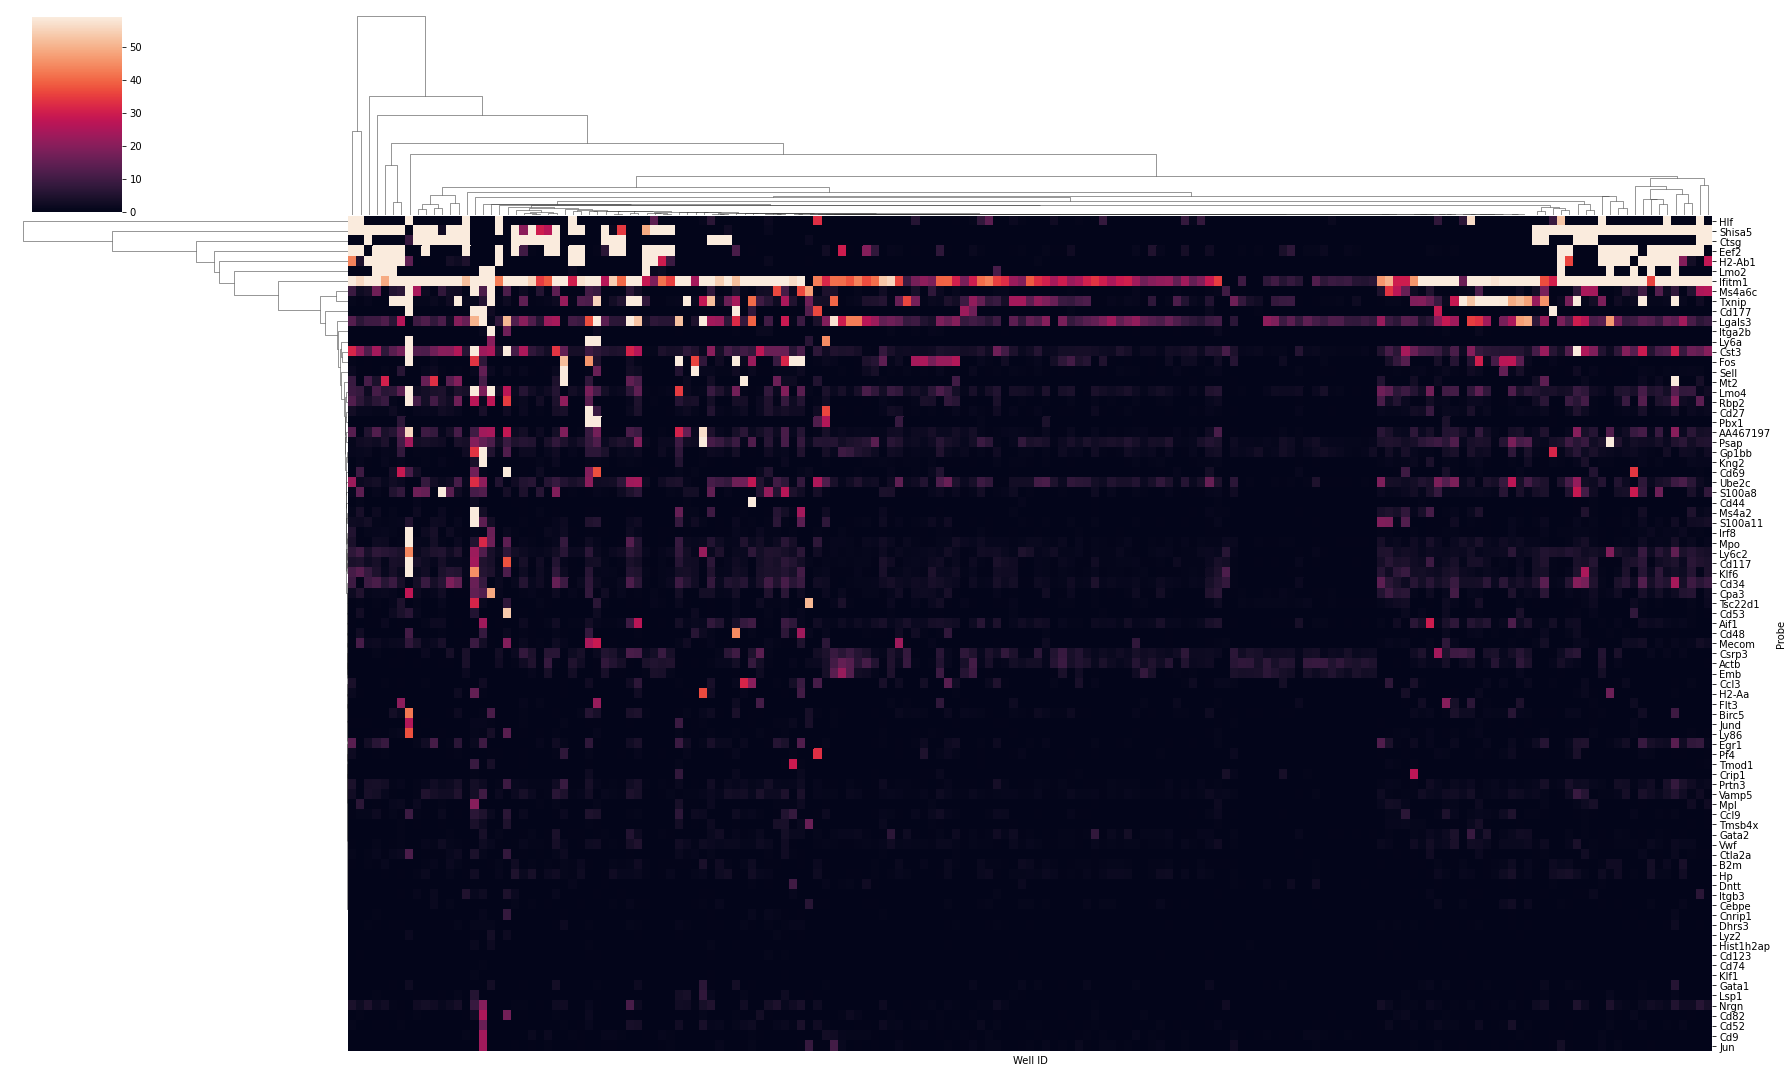

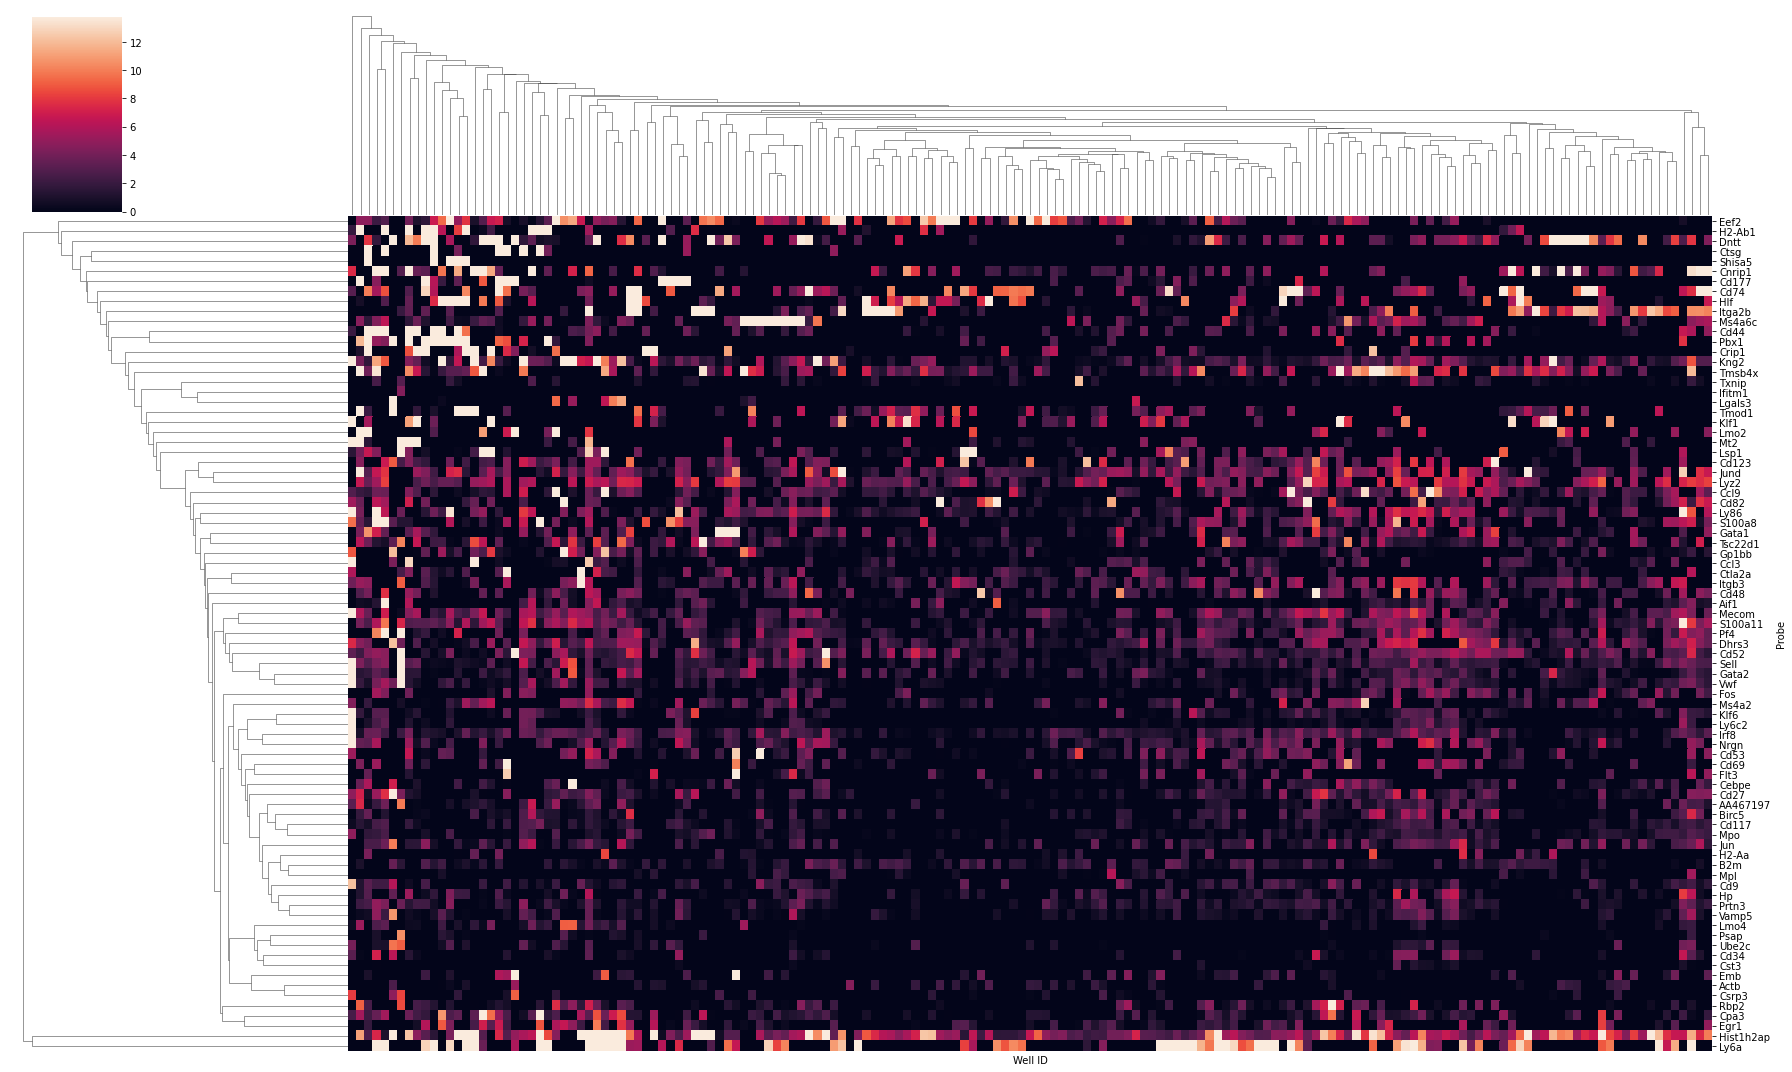

In [68]:
sns.clustermap(rna_xprsn.transpose(), figsize=(25,15), method = 'average', robust = True, xticklabels = False, yticklabels = True, vmin = 0)
sns.clustermap(rna_df.replace(np.nan, 0).transpose(), figsize=(25,15), method = 'average', robust = True, xticklabels = False, yticklabels = True, vmin = 0)

Can color individual leaves to show which markers correspond with which celltypes  
https://python-graph-gallery.com/405-dendrogram-with-heatmap-and-coloured-leaves/

#### Z_score norm

A note about z_scores:  
> Z scores are: z = (x - mean)/std, so values in each row will get the mean of the row subtracted, then divided by the standard deviation of the row.  
> This ensures that each row has mean of 0 and variance of 1.  

Either 0 (rows) or 1 (columns):  
> 0 = Set the mean of each __gene__ to zero and see which cells express it the most  
> 1 = Set the mean of each __cell__ to zero and see which genes are most variable in it  

Z score across cells.  
Do you do z_score then dCt, or dCt then z_score, or just z_score?  
I think z_score is the cell norm method, so will try just z_score

In [69]:
rna_zscore = dCt(rna_df)
rna_zscore = zscore_norm(rna_zscore)
rna_zscore = dCt_xprsn(rna_zscore).transpose()

##### Hierarchical clustering

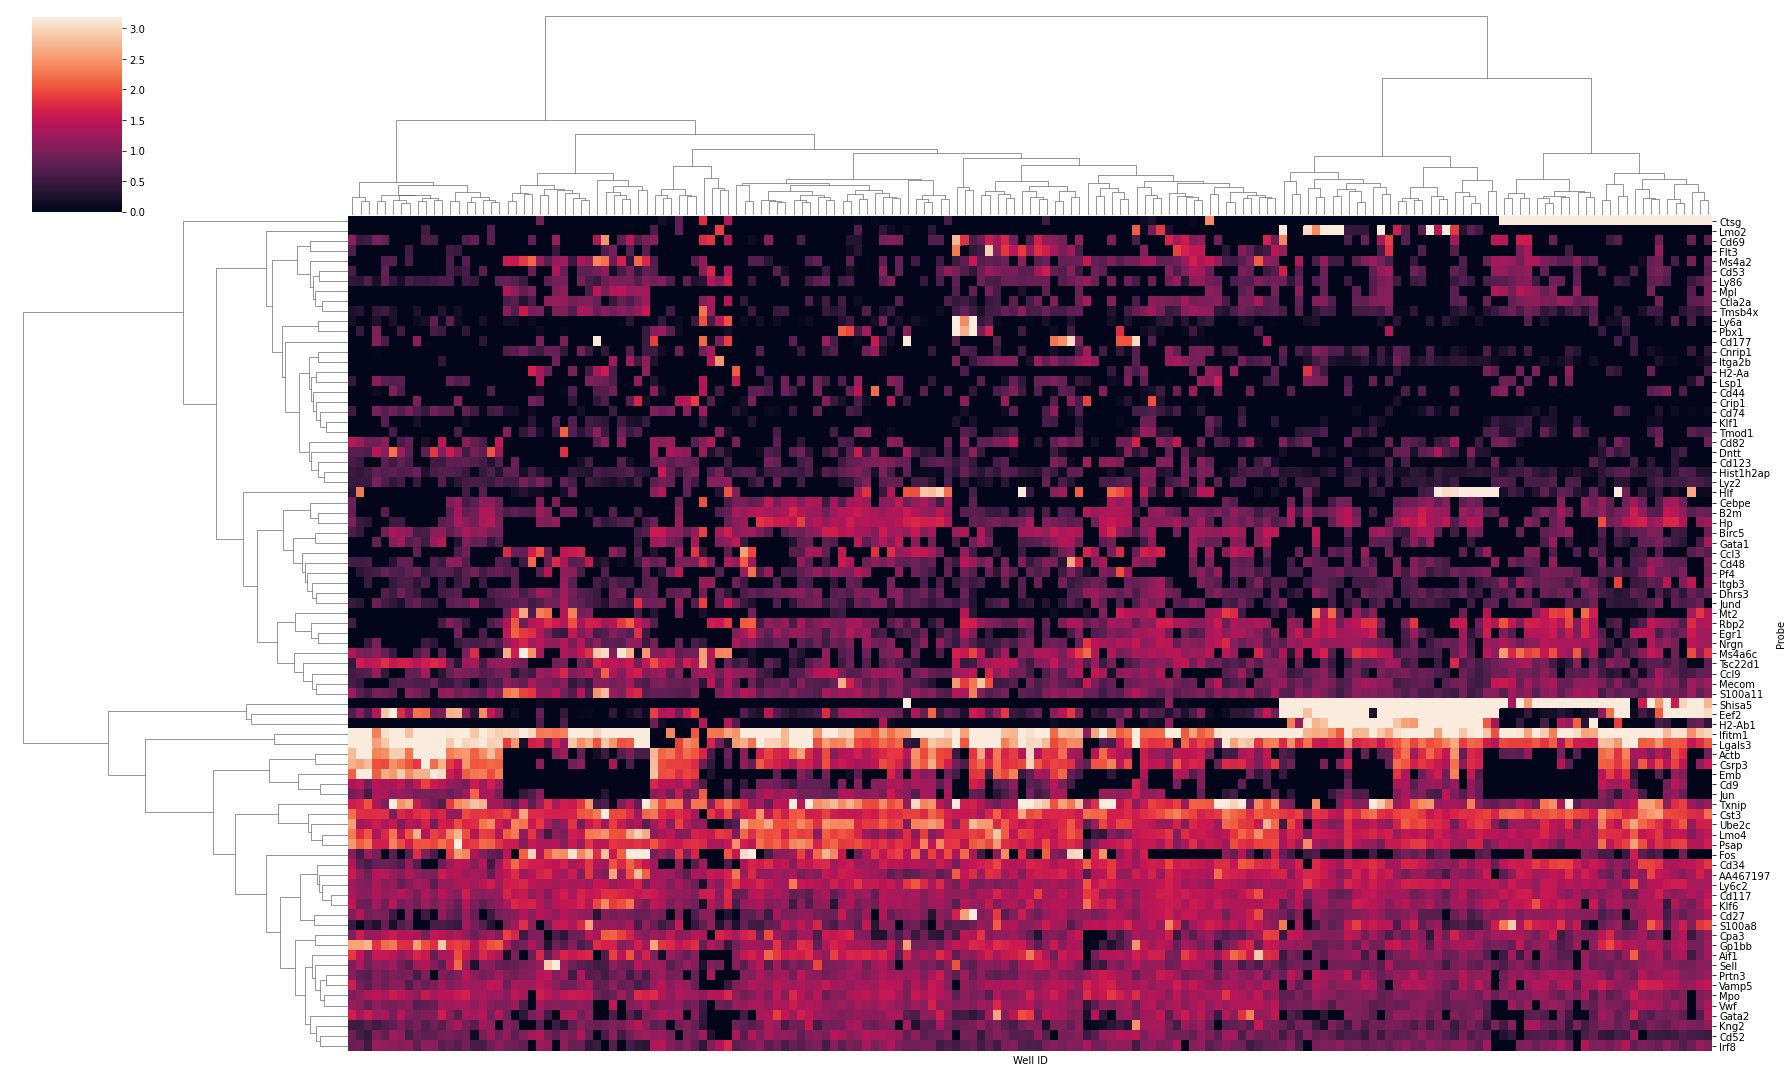

In [129]:
sns.clustermap(rna_zscore, figsize=(25,15), method = 'ward', robust = True, xticklabels = False, yticklabels = True, vmin = 0)

##### Hierarchical clustering - excluding plate-specific genes

Plates 12 and 13 unusually enriched for Shisa5 and Eef2. In addition, P12 has very high H2-Ab1 and P13 has very high Ctsg.  
try exluding these and then re-cluster

In [132]:
rna_zscore_lim = rna_zscore.copy()
rna_zscore_lim = rna_zscore_lim.drop(['Shisa5', 'Eef2', 'H2-Ab1', 'Ctsg'], axis = 0)

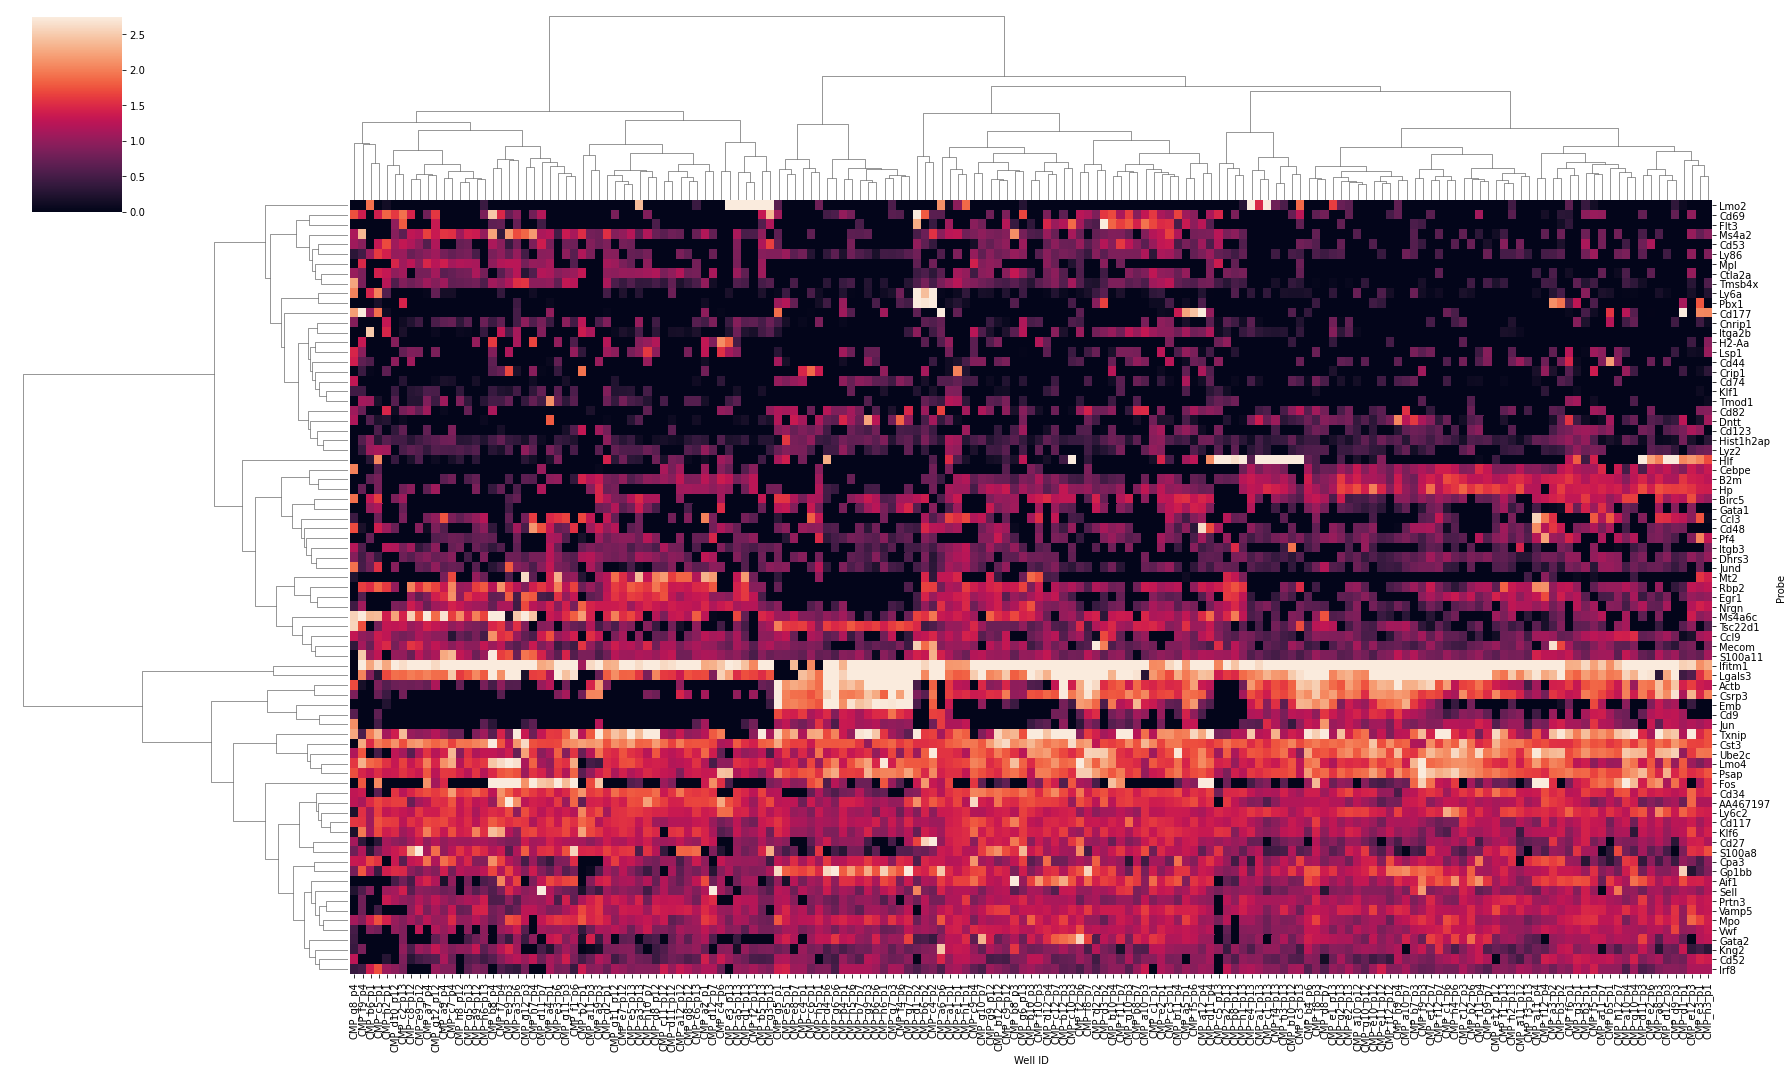

In [135]:
sns.clustermap(rna_zscore_lim, figsize=(25,15), method = 'ward', robust = True, xticklabels = True, yticklabels = True, vmin = 0)

not perfect but definitely better

#### Sklear.StandardScaler()

I guess if you assume each plate has the same distribution of cell types, then you can assume that plates represent a gaussian distribution of an expression profile.  
So we can scale each plate, which should make inter-plate comparisons more fair

In [45]:
from sklearn import preprocessing

__Is this normalizing across each cell??__

In [47]:
rna_df

Probe,AA467197,Actb,Aif1,B2m,Birc5,Ccl3,Ccl9,Cd117,Cd123,Cd177,...,S100a8,Sell,Shisa5,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf
Well ID,,,,,,,,,,,,,,,,,,,,,
CMP_a1_p1,0.397845,-0.762792,0.458386,NaN,3.561568,-1.132644,1.646315,0.762792,NaN,NaN,...,1.504188,2.910428,27.480742,2.124372,3.884586,3.842558,-0.613218,-0.533507,0.632748,0.853020
CMP_a2_p1,-2.723805,NaN,-3.017012,0.529171,NaN,-4.969267,0.523014,-0.529171,NaN,3.347077,...,NaN,1.101495,27.316213,23.766987,3.094573,NaN,0.709287,-4.065883,-1.547669,0.242774
CMP_a4_p1,-0.267963,0.086838,-2.856932,2.258887,NaN,-1.593589,-3.044494,-2.345725,NaN,2.057218,...,-2.170673,0.346814,NaN,-4.877128,2.025046,2.301058,-2.382982,0.648830,3.165029,1.732569
CMP_a5_p1,-0.700463,-1.915669,6.039691,NaN,-0.246907,13.016284,4.478656,1.915669,4.473789,-4.511179,...,1.332149,3.066684,NaN,NaN,10.432280,-0.179366,-3.206007,-0.780083,0.605342,1.489531
CMP_b2_p1,9.886838,NaN,NaN,1.521964,NaN,-0.297284,NaN,-1.521964,2.540754,NaN,...,1.317012,24.945457,NaN,NaN,NaN,10.189974,3.096391,9.088096,-0.290650,16.790250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CMP_g6_p13,-2.455212,0.726291,0.594564,1.450726,NaN,NaN,NaN,-2.177017,0.319494,NaN,...,-4.444931,1.455916,-0.290012,6.790958,5.348332,0.737139,-2.585740,-0.633442,-0.993344,-0.617315
CMP_h1_p13,0.296912,2.594379,-0.343863,-0.729117,NaN,2.904391,1.846465,-1.865263,NaN,NaN,...,3.586937,0.526429,-10.658117,NaN,7.092461,4.427403,-0.396551,-2.250369,-1.670532,1.371868
CMP_h2_p13,-0.248035,-0.073031,0.038398,-1.325008,2.200940,1.621605,2.197597,1.398038,3.334230,NaN,...,-1.598139,1.158157,-9.133728,NaN,NaN,5.374930,-1.235640,-2.390884,-0.037609,0.669033


In [83]:
rna_with_pid = rna_df.copy()
rna_with_pid['pid'] = rna.index.map(lambda x: re.search('p\d+$', x).group(0))
rna_df_by_pid = rna_with_pid.groupby('pid')

In [90]:
rna_scaled_list = []

for pid in rna_df_by_pid.groups.keys():
    
    df = rna_df_by_pid.get_group(pid).transpose()
    df = df.drop('pid', axis = 0)
    
    scaler = preprocessing.StandardScaler().fit(df)
    df_scaled = scaler.transform(df)
    df_scaled = pd.DataFrame(df_scaled, index = df.index, columns=df.columns)
#     ic(df_scaled.shape[0], df_scaled.mean(axis = 0), df_scaled.std(axis = 0))
    
    rna_scaled_list.append(df_scaled.transpose())
    
    
rna_scaled = pd.concat(rna_scaled_list)
rna_scaled = rna_scaled.replace(np.nan, 0)

##### Hierarchical clustering

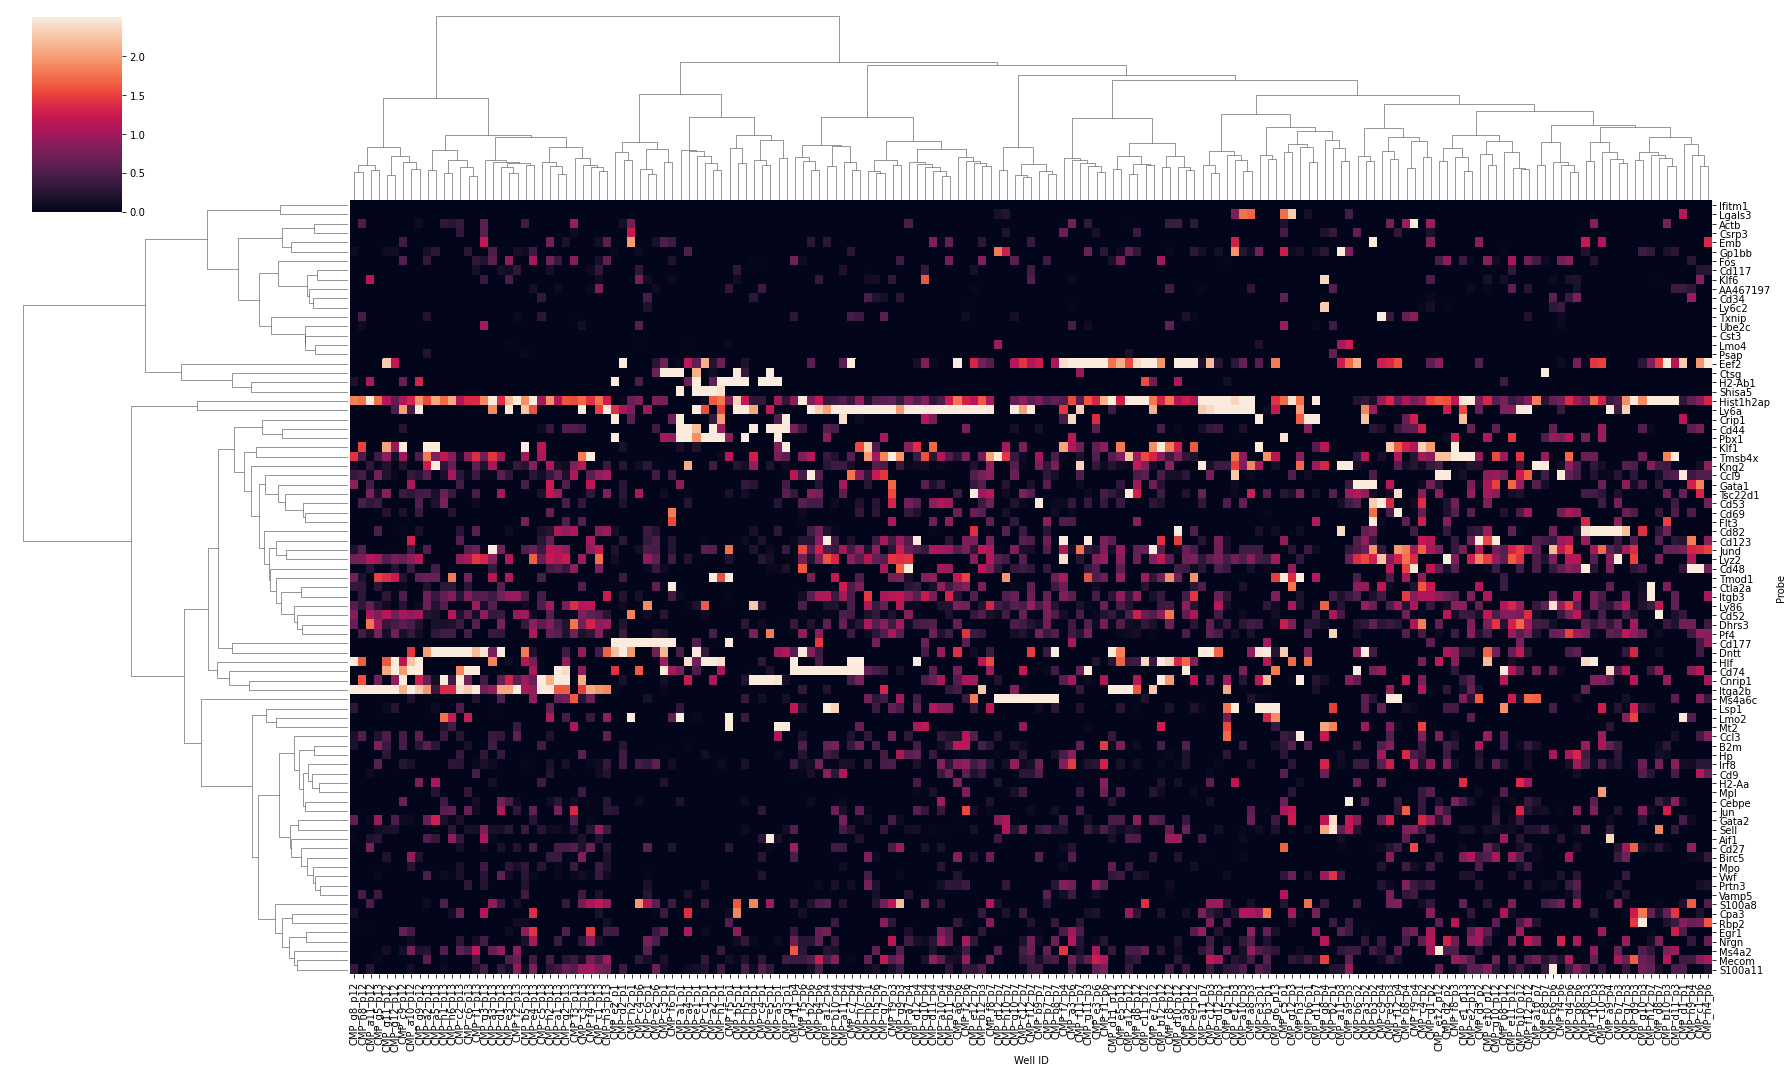

In [128]:
sns.clustermap(rna_scaled.transpose(), figsize=(25,15), method = 'ward', robust = True, xticklabels = True, yticklabels = True, vmin = 0)

#### Sklearn.RobustScaler()

In [94]:
rna_df_by_pid = rna_with_pid.groupby('pid')

In [97]:
rna_robust_list = []

for pid in rna_df_by_pid.groups.keys():
    
    df = rna_df_by_pid.get_group(pid).transpose()
    df = df.drop('pid', axis = 0)
    
    scaler = preprocessing.RobustScaler().fit(df)
    df_scaled = scaler.transform(df)
    df_scaled = pd.DataFrame(df_scaled, index = df.index, columns=df.columns)
#     ic(df_scaled.shape[0], df_scaled.mean(axis = 0), df_scaled.std(axis = 0))
    
    rna_robust_list.append(df_scaled.transpose())
    
    
rna_robust = pd.concat(rna_robust_list)
rna_robust = rna_robust.replace(np.nan, 0)

##### Hierarchical clustering

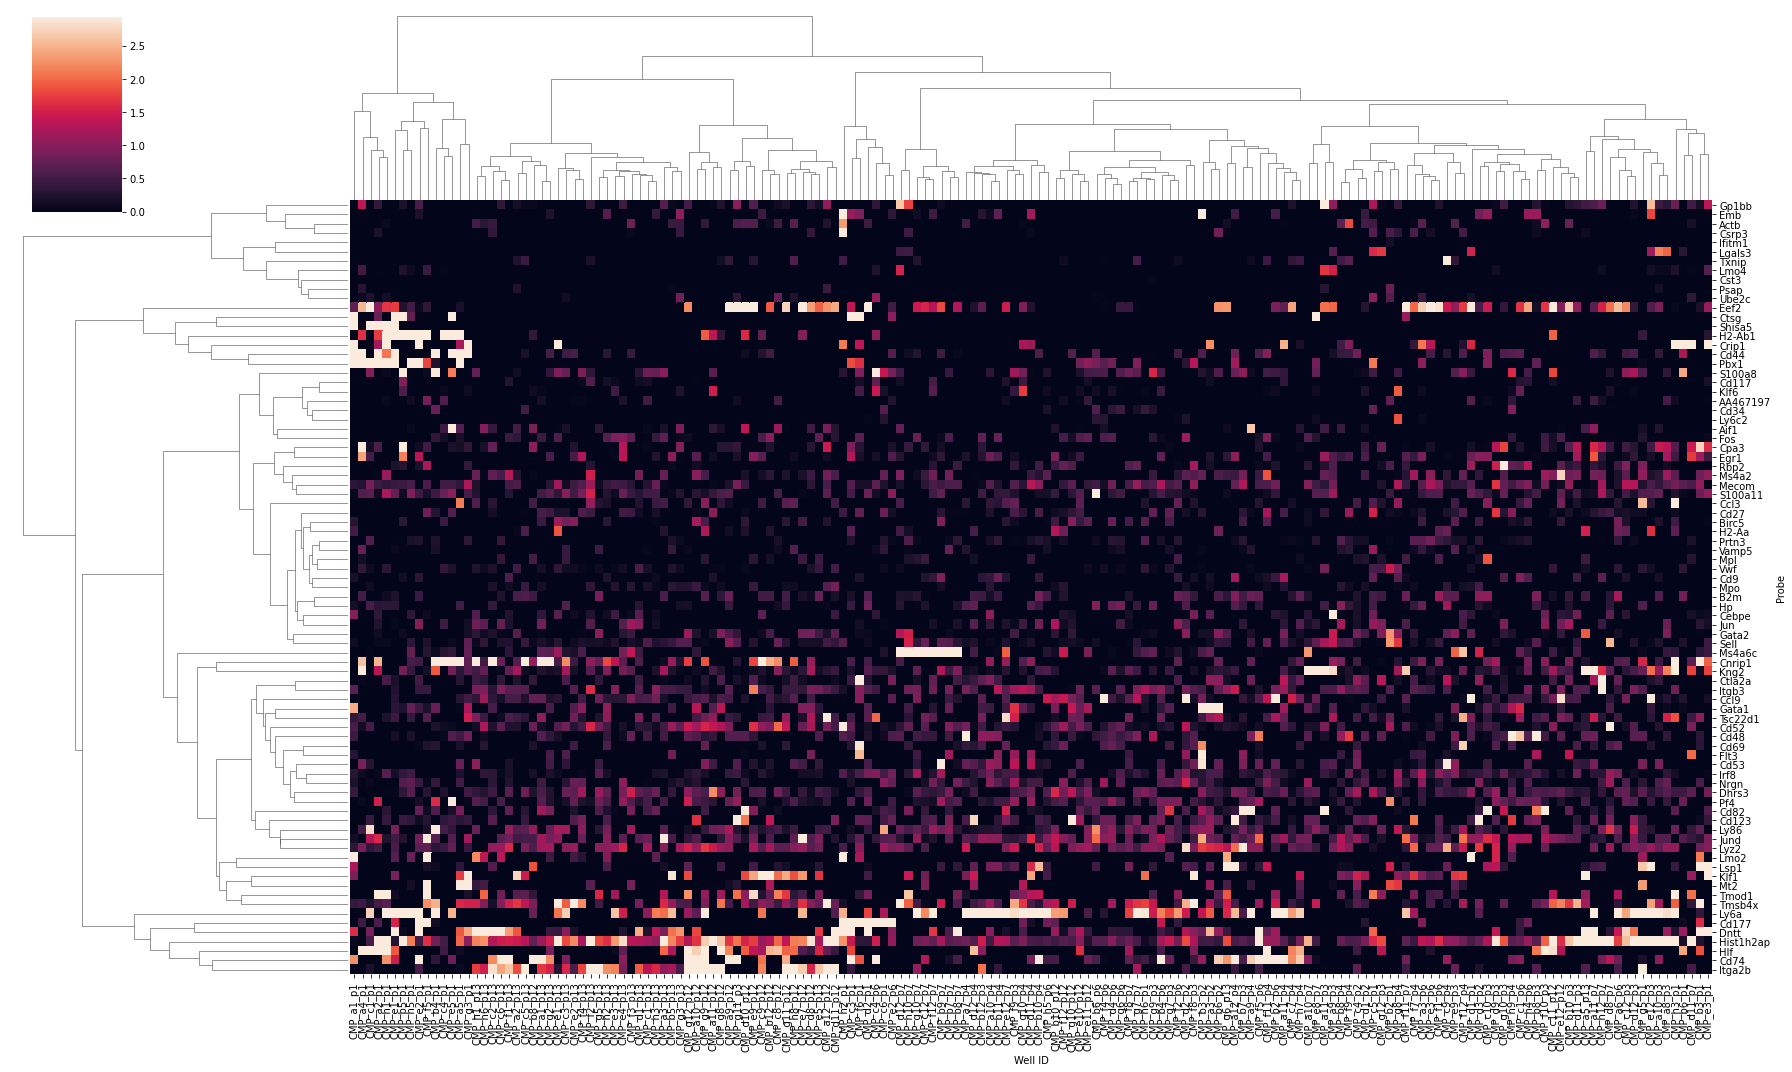

In [98]:
sns.clustermap(rna_robust.transpose(), figsize=(25,15), method = 'ward', robust = True, xticklabels = True, yticklabels = True, vmin = 0)

RobustScaler is supposed to handle outliers better, but now I get a tv screen. And p13 is clumping like a beast...     
__Perform an outlier test before deciding on these results__

## Normalization notes  
[Fluidigm](https://www.fluidigm.com/faq/ge-63) suggests normalizing my _median_ Ct  
Should reinvestigate the biomark software itself and make absolutely sure there's no way to normalize through that...

### Quantile normalization

## MFI df

### Filter

In [100]:
mfi_df = mfi.loc[mfi.index.isin(shared_idx), ]

### Hitogram of unmodified flow data

In [101]:
mfi_by_pid = mfi_df.groupby('pid')
mfi_by_pid.groups.keys()

dict_keys(['p1', 'p12', 'p13', 'p2', 'p3', 'p4', 'p6', 'p7'])

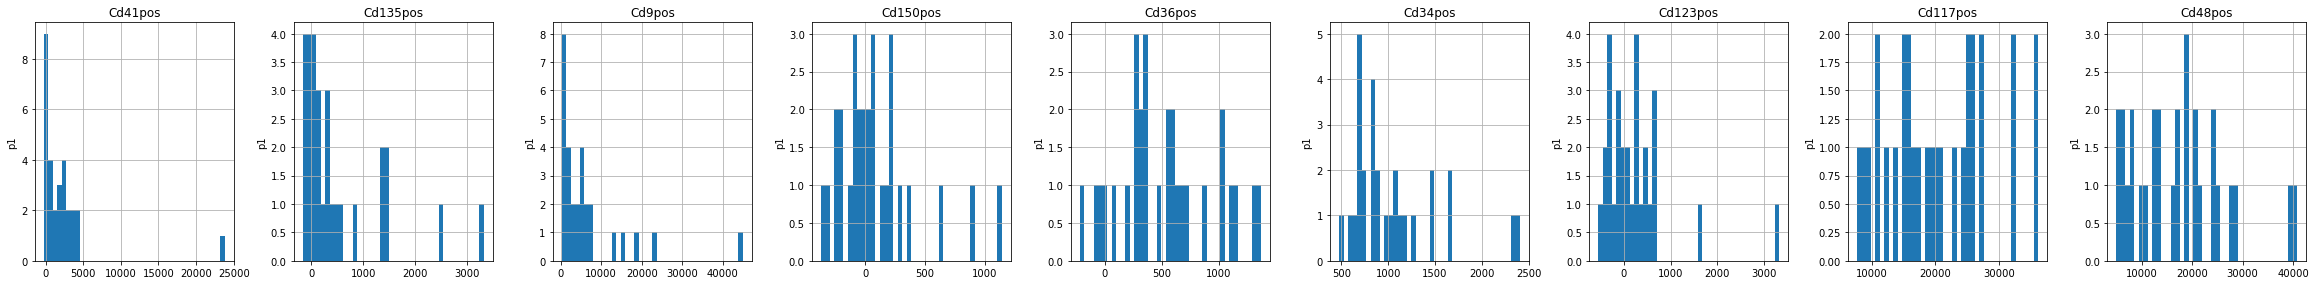

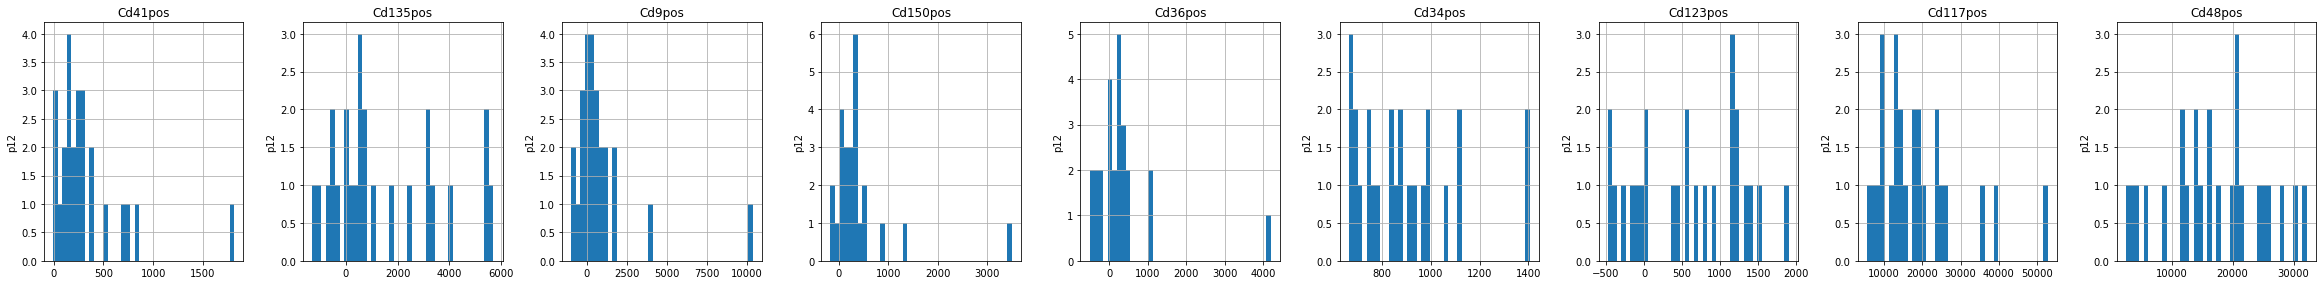

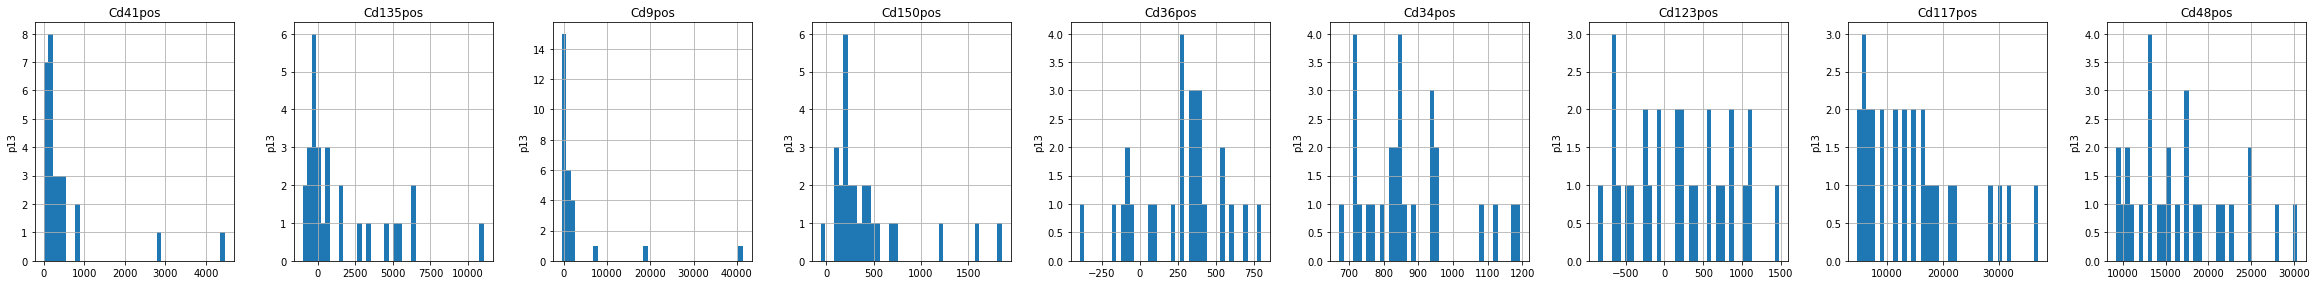

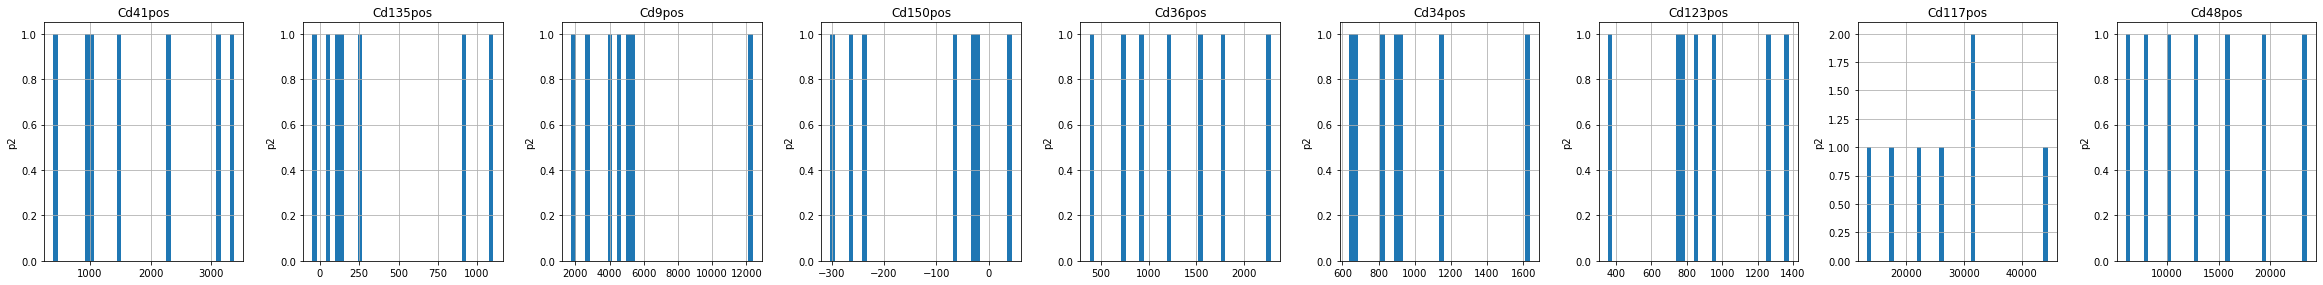

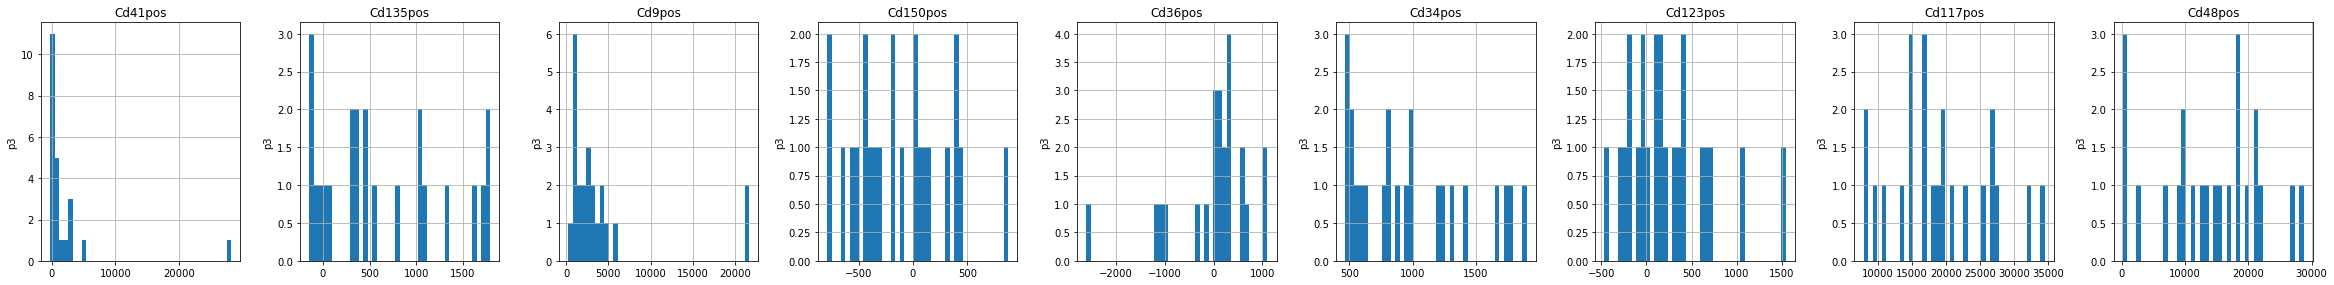

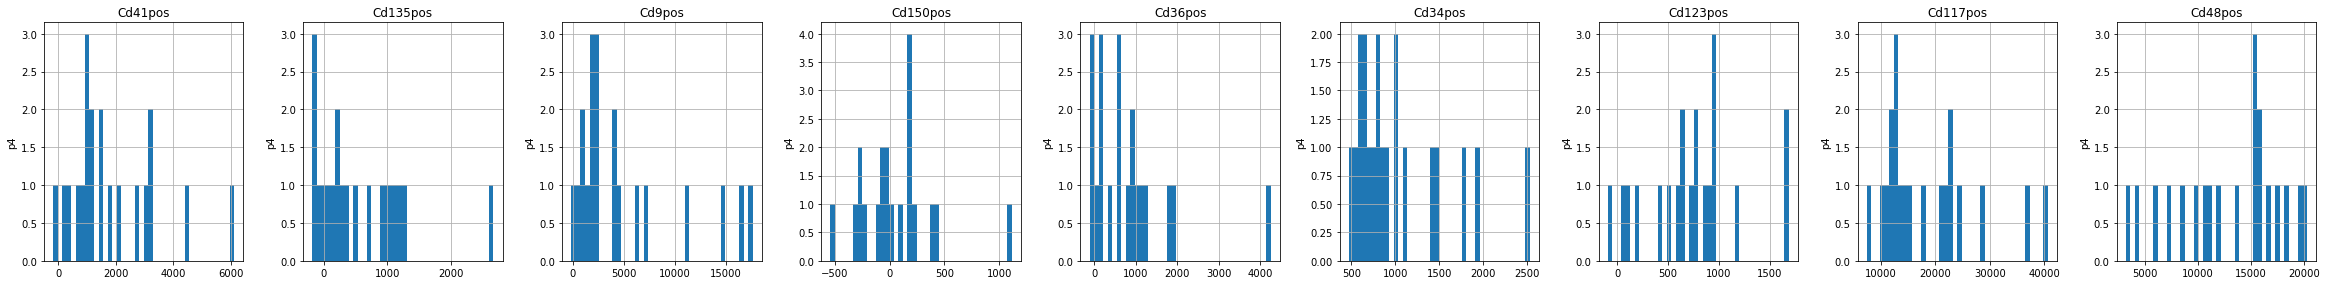

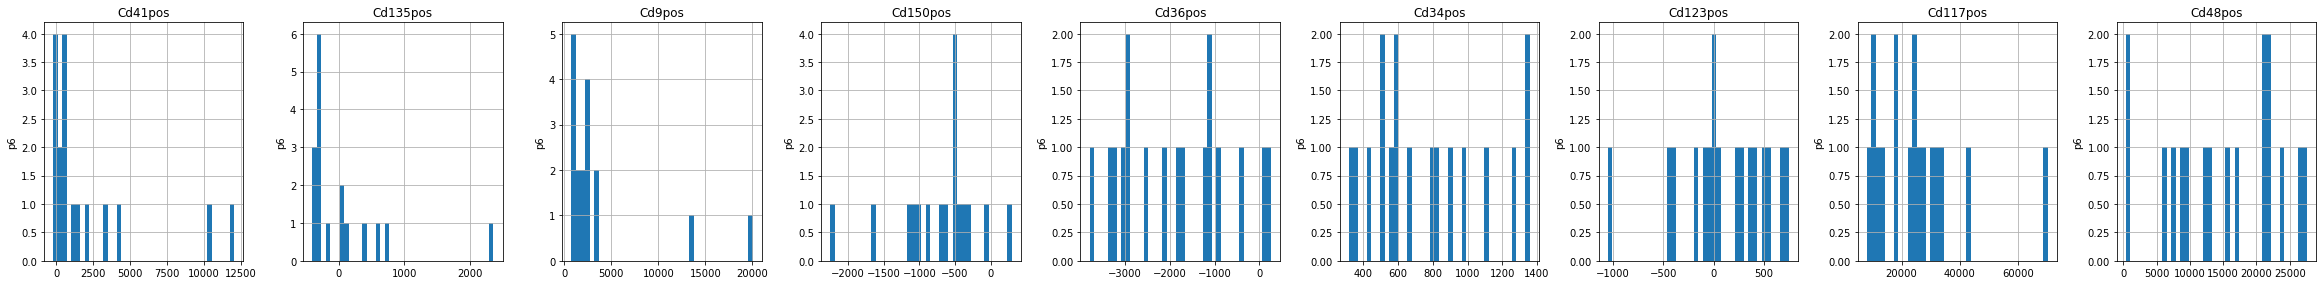

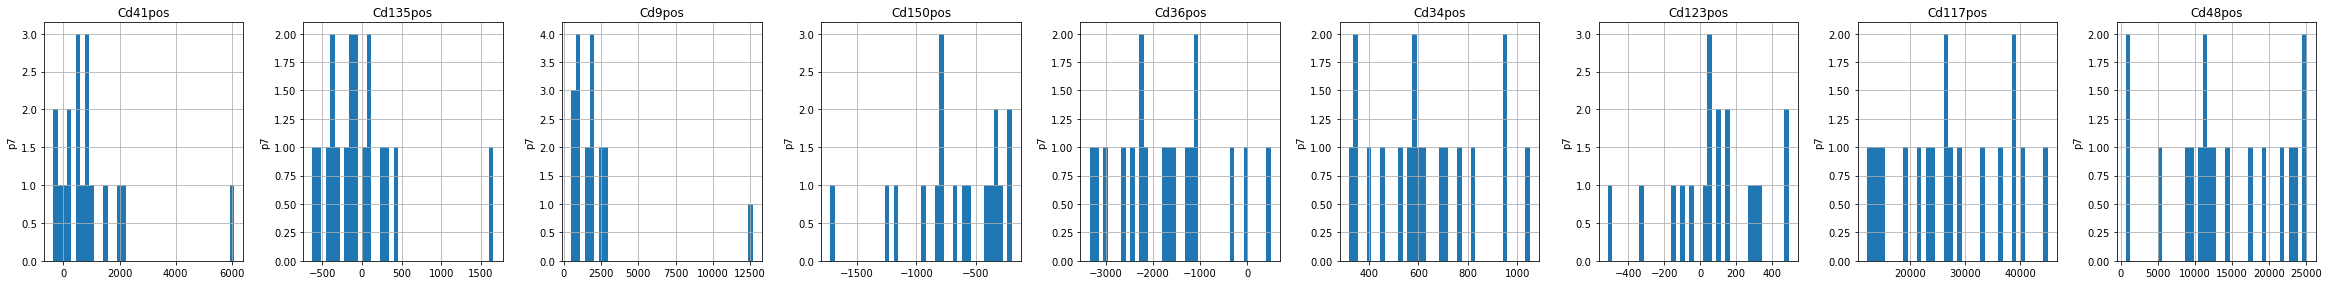

In [102]:
for plate in mfi_by_pid.groups.keys():
    plot_group = mfi_by_pid.get_group(plate)
    plot_group = plot_group.replace(np.nan, 0)
    
    for array in plot_group.hist(bins = 40, layout = (9, 11), figsize = (50, 50)):
        for subplot in array:
            subplot.set_ylabel(plate)
#             subplot.set_xlim(left = 0)


In [103]:
rdbu = sns.diverging_palette(250, 10, s = 100, l=50, sep = 1,  center= "dark", as_cmap=True)

### MFI above background

Problem with zscore norm is that it doesn't necessarily preserve fluourescence distribution  
Went throught each experiment and calculated minimum MFI that was still "positive" above background (i.e., Cd34 MFI 161 = Cd34- but Cd34 MFI 162 = Cd34+)  
For ease, going to just call this "background"  
Will subtract background from fluor for each experiment, then normalize between 1 and 100 <- this will preserve distribution of "positive" values

#### Define backgrounds for each experiment

In [104]:
bkgd_dict = {'010319': {'Cd34pos': 162, 'Cd117pos': 1200, 'Cd9pos': 1100, 'Cd36pos': 1300, 'Cd41pos': 433, 'Cd48pos': 89, 'Cd123pos': 314, 'Cd150pos': 415, 'Cd135pos': 433},
             '020119': {'Cd34pos': 222, 'Cd117pos': 356, 'Cd9pos': 1100, 'Cd36pos': 204, 'Cd41pos': 430, 'Cd48pos': 156, 'Cd123pos': 305, 'Cd150pos': 419, 'Cd135pos': 27},
             '090618': {'Cd34pos': 593, 'Cd117pos': 419, 'Cd9pos': 376, 'Cd36pos': 828, 'Cd41pos': 431, 'Cd48pos': 197, 'Cd123pos': 960, 'Cd150pos': 618, 'Cd135pos': 1000},
             '121218': {'Cd34pos': 205, 'Cd117pos': 454, 'Cd9pos': 593, 'Cd36pos': 1300, 'Cd41pos': 755, 'Cd48pos': 91, 'Cd123pos': 1600, 'Cd150pos': 439, 'Cd135pos': 445}
            }

In [105]:
mfi_by_sortdate = mfi_df.groupby('sortdate')
mfi_by_sortdate.get_group('010319').head(2)

,Well,Cd41pos,Cd135pos,Cd9pos,Cd150pos,Cd36pos,Cd34pos,Cd123pos,Cd117pos,Cd48pos,sortdate,plateid,pid
Well,,,,,,,,,,,,,
CMP_a1_p1,a1,2016.948658,16.446109,1303.250688,-68.335742,75.990236,1167.851376,227.502089,14971.870215,18679.358359,010319,002_015,p1
CMP_a10_p3,a10,974.525253,565.503227,3515.072143,-505.684552,162.701193,771.356098,1068.511986,34483.018533,9763.400289,010319,001_014,p3


In [106]:
mfi_sortdate_list = []

for sortdate in mfi_by_sortdate.groups.keys():
    mfi_subbkgd = mfi_by_sortdate.get_group(sortdate)
    sortdate_math = bkgd_dict[sortdate]
    for fluor in sortdate_math.keys():
        
        mfi_subbkgd[fluor] = mfi_subbkgd[fluor] - sortdate_math[fluor] # sets min positive value to 0
#         ic(fluor, sortdate, 
#            mfi_subbkgd[fluor].min(), 
#            mfi_subbkgd[fluor].max()
#           )
        mfi_subbkgd[fluor] = mfi_subbkgd[fluor].clip(lower = 0)
        mfi_subbkgd[fluor] = mfi_subbkgd[fluor]/mfi_subbkgd[fluor].max()
    
    mfi_sortdate_list.append(mfi_subbkgd)
mfi_sortdate = pd.concat(mfi_sortdate_list)

/Users/heustonef/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/heustonef/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/heustonef/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [107]:
mfi_sortdate.head(2)

,Well,Cd41pos,Cd135pos,Cd9pos,Cd150pos,Cd36pos,Cd34pos,Cd123pos,Cd117pos,Cd48pos,sortdate,plateid,pid
Well,,,,,,,,,,,,,
CMP_a1_p1,a1,0.056931,0.000000,0.004636,0.0,0.0,0.447660,0.000000,0.393804,0.456239,010319,002_015,p1
CMP_a10_p3,a10,0.019464,0.045709,0.055085,0.0,0.0,0.271198,0.251106,0.951721,0.237426,010319,001_014,p3


#### Histogram of corrected data

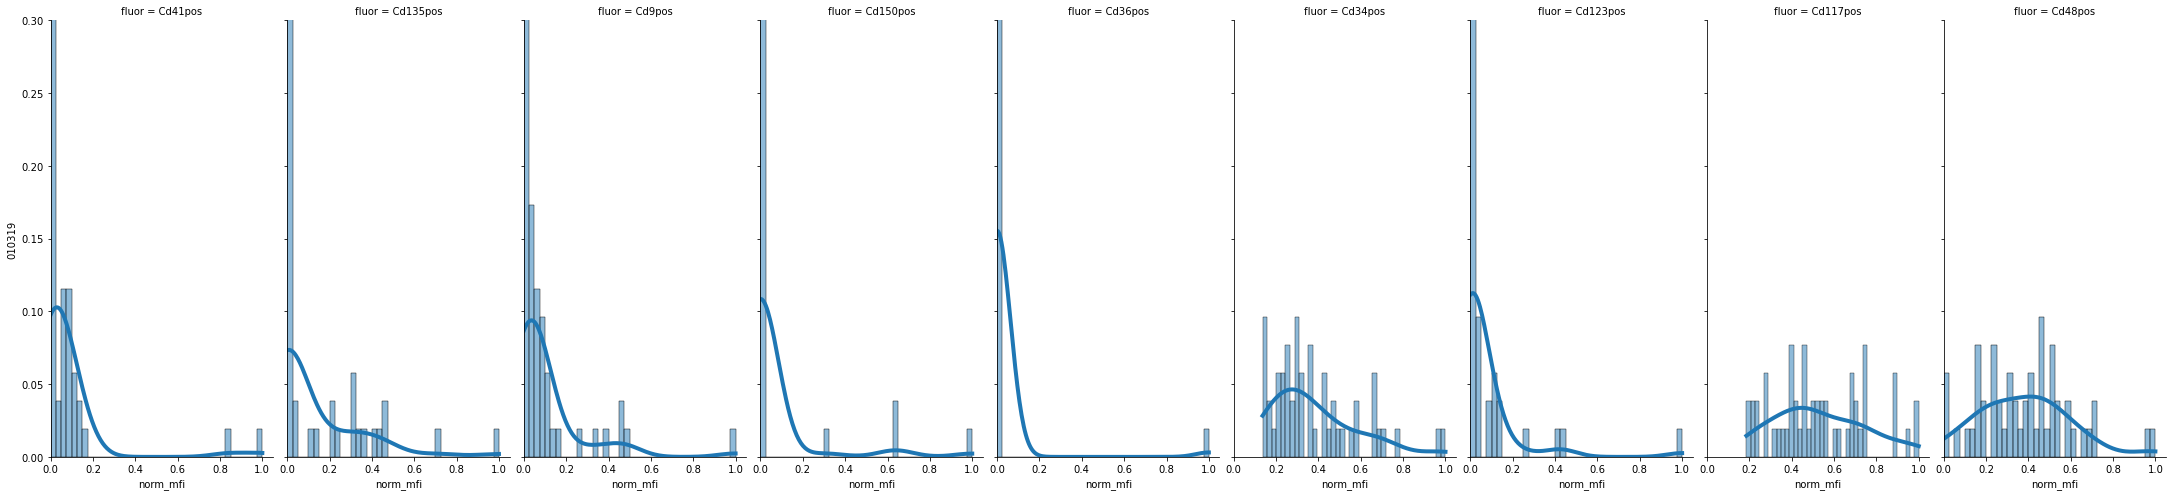

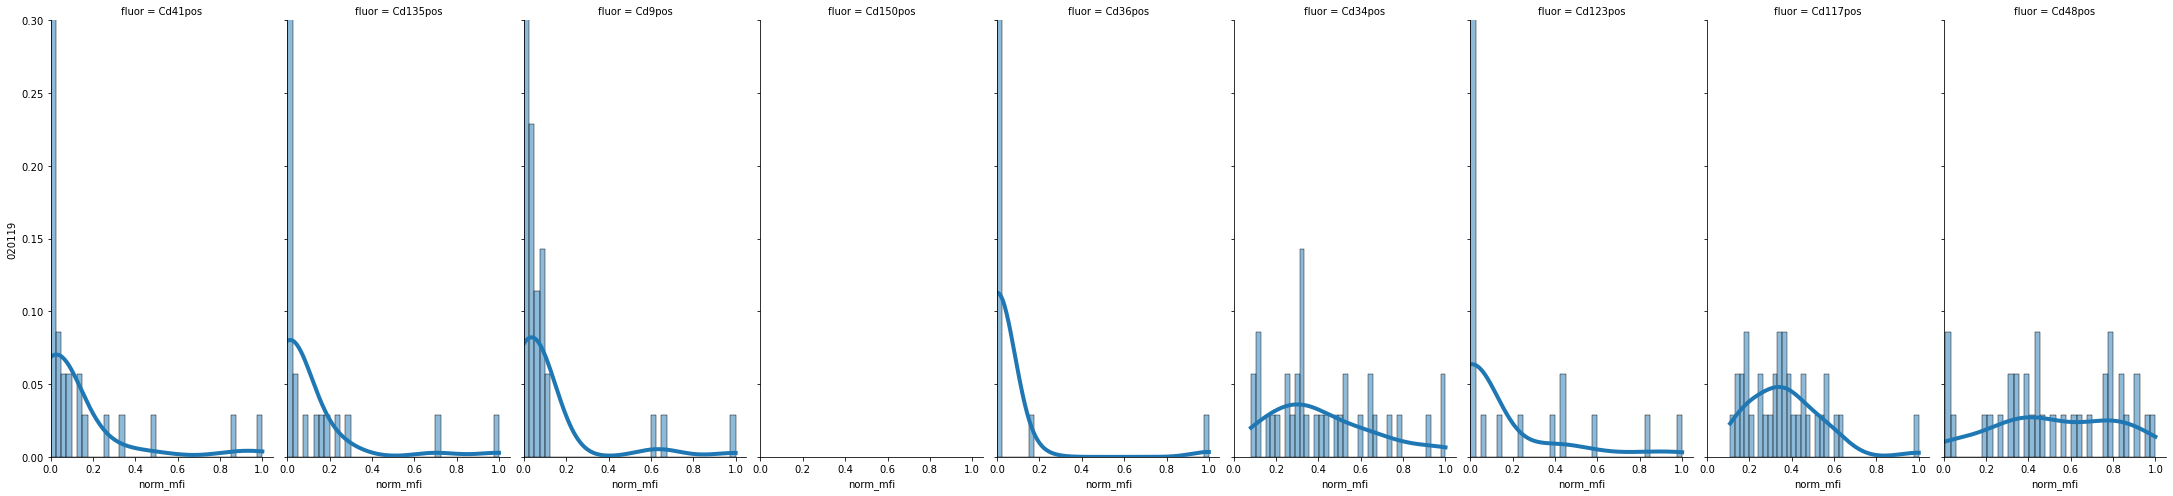

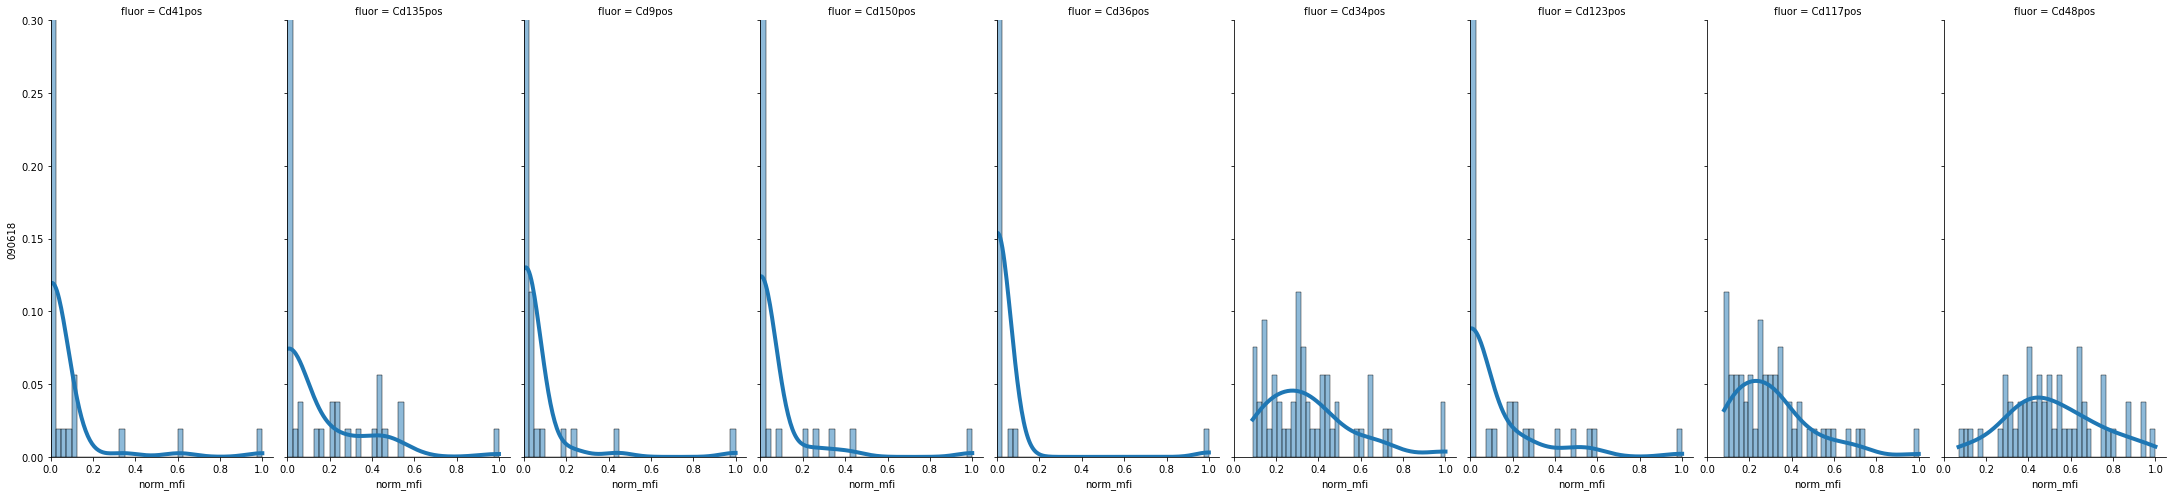

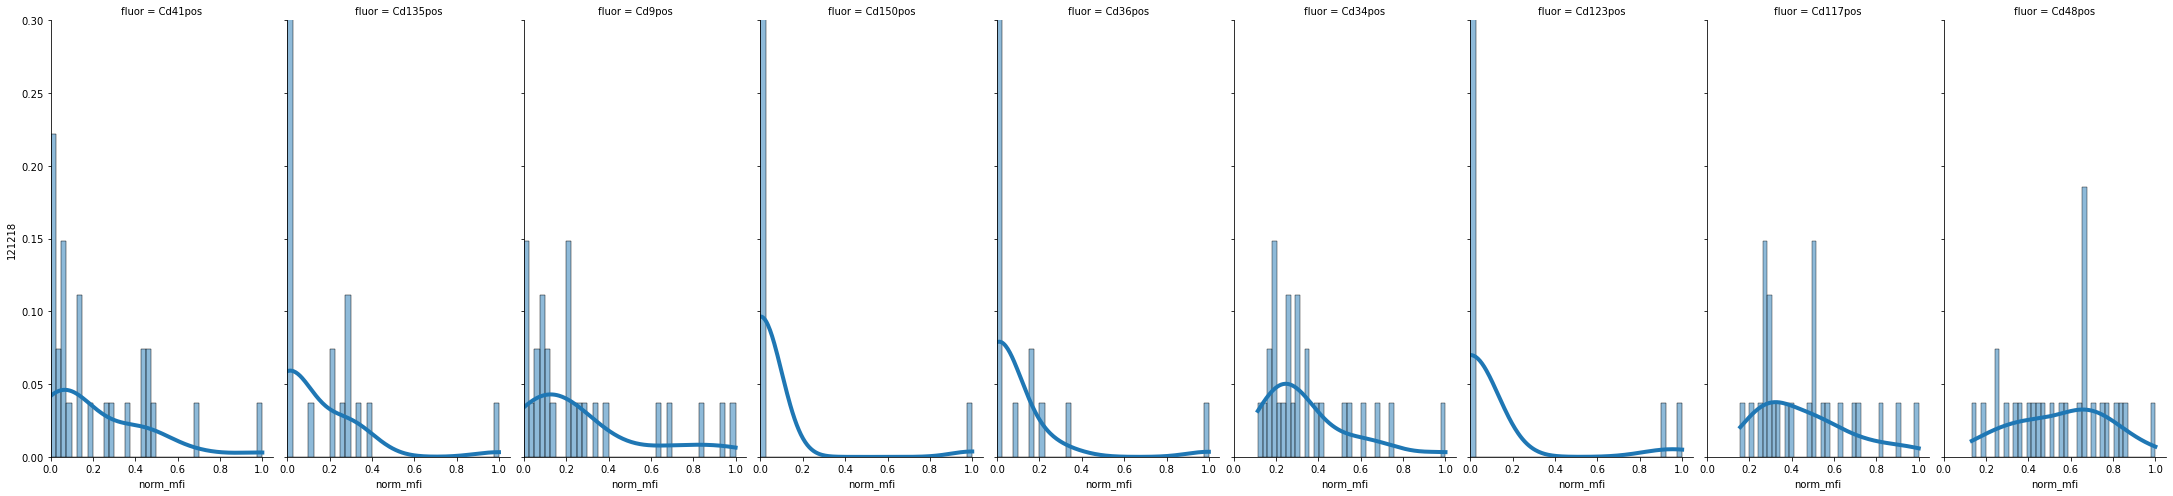

In [108]:
mfi_sortdate_by_sortdate = mfi_sortdate.groupby('sortdate')
for plate in mfi_sortdate_by_sortdate.groups.keys():
    plate_df = mfi_sortdate_by_sortdate.get_group(plate)
    plate_df = plate_df.drop(['Well', 'sortdate', 'plateid', 'pid'], axis = 1)
#     ic(plate, 
#        plate_df.min(), 
#        plate_df.max()
#       )
    plate_df = pd.melt(plate_df).rename(columns={'variable': 'fluor', 'value': 'norm_mfi'})
    
    # create figures
    g = sns.FacetGrid(plate_df, col = 'fluor')
    g.fig.set_size_inches(30, 7)
    g.map(sns.histplot, 'norm_mfi', bins = 40, stat = 'probability', kde = True, line_kws = {'linewidth':4})
    g.set_axis_labels(y_var=plate)
    plt.xlim(left = 0)
    plt.ylim(top = 0.3)
    
#     #save figures
#     save_title = ''.join(('bkgd_norm_mfi-biomarkCells-', plate, '.png'))
#     plt.savefig(save_title)

In [109]:
mfi_mtx = mfi_sortdate[['Cd41pos', 'Cd135pos', 'Cd9pos', 'Cd150pos', 'Cd36pos', 'Cd34pos', 'Cd123pos', 'Cd117pos', 'Cd48pos']].replace(np.nan, 0)

#### Hierarchical clustering

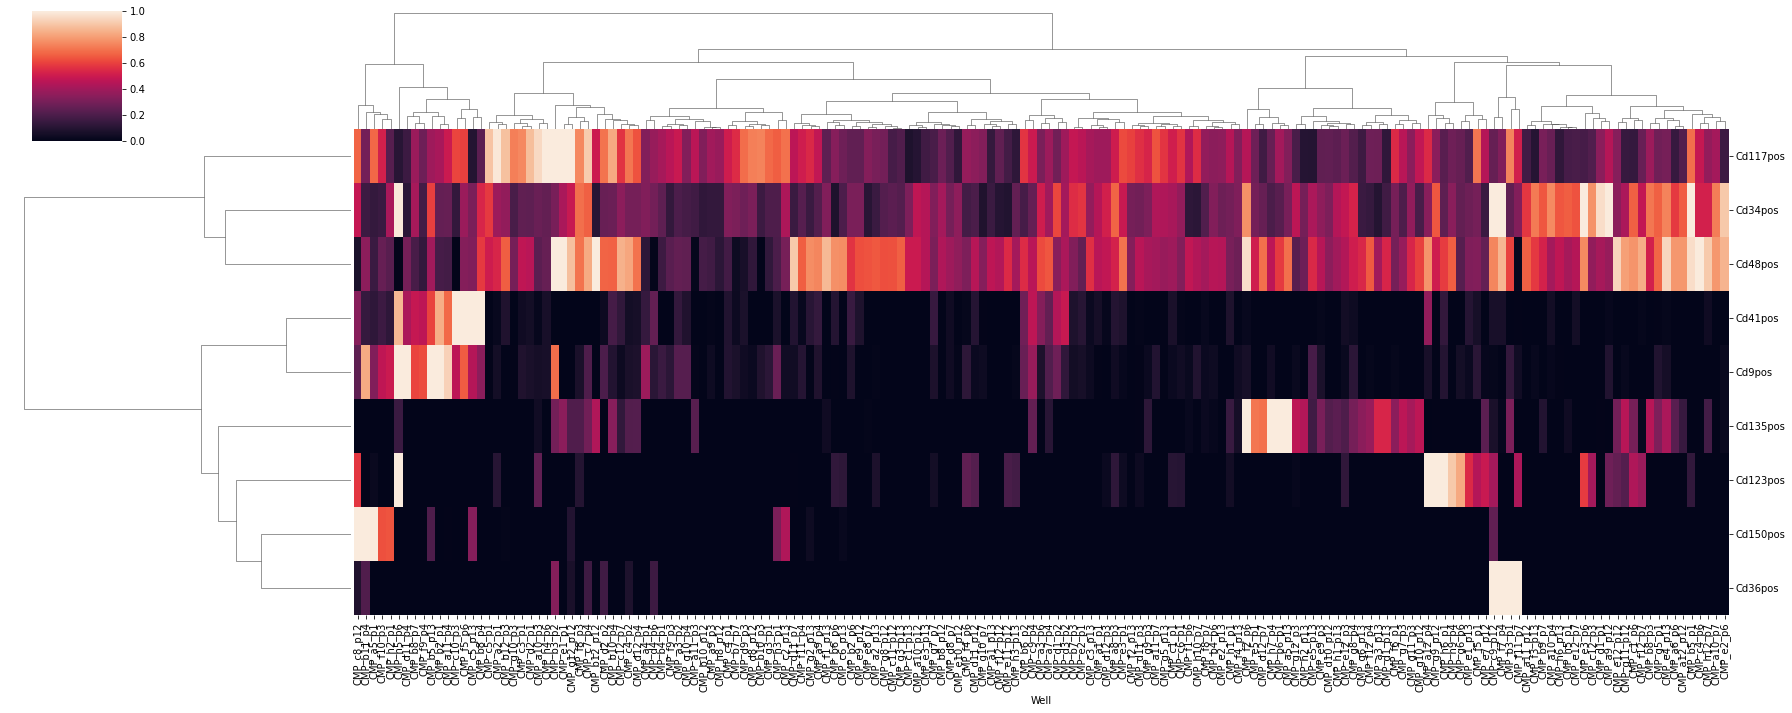

In [110]:
sns.clustermap(mfi_mtx.transpose(), figsize=(25,10), method = 'ward', robust = True, xticklabels = True, yticklabels = True, vmin = 0, vmax = 1)

#### PCA

Use mfi_sortdate because want to keep batch info

In [111]:
mfi_pca = mfi_sortdate.drop(['Well', 'sortdate', 'plateid'], axis = 1)
mfi_pca['pid'] = mfi['pid'].astype('category')

In [112]:
pca = PCA(n_components=20)
# pca_result = pca.fit_transform(cluster_df.iloc[:, :-1].values)
pca_result = pca.fit_transform(mfi_pca.values)
pca_df = mfi_pca.copy()
pca_df['pca-one'] = pca_result[:,0]
pca_df['pca-two'] = pca_result[:,1] 
pca_df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

ValueError: could not convert string to float: 'p1'

In [ ]:
# fig, axes = plt.subplots(1, 2)
plt.figure(figsize=(12, 7))
sns.scatterplot(
#     ax = axes[0], 
    x="pca-one", y="pca-two",
    hue="pid",
    palette=sns.color_palette("hls", len(pca_df['pid'].unique())),
    data=pca_df,
    legend="full",
    alpha=0.7, 
    s = 100
)


# Combine Biomark and MFI data

There are 2 ways to do this:  
> Combine the data then cluster, letting flow marker contribute to hierarchy  
> Cluster the biomark data, then tack on the appropriate flow markers  

Easiest should be to combine the data then cluster, so I'll start there

## Combine data

### Merge

Use `pd.merge(how = 'left')`

In [113]:
rna_zscoreT = rna_zscore.transpose()

In [114]:
combined_df = rna_zscoreT.merge(mfi_mtx, how='left', right_on=mfi_mtx.index, left_index=True).drop("key_0", axis = 1).transpose()
combined_df.shape

(92, 167)

In [115]:
combined_df.head(3)

Well,CMP_a1_p1,CMP_a2_p1,CMP_a4_p1,CMP_a5_p1,CMP_b2_p1,CMP_b3_p1,CMP_b4_p1,CMP_b5_p1,CMP_b6_p1,CMP_c1_p1,...,CMP_f3_p13,CMP_f4_p13,CMP_g2_p13,CMP_g3_p13,CMP_g5_p13,CMP_g6_p13,CMP_h1_p13,CMP_h2_p13,CMP_h3_p13,CMP_h6_p13
AA467197,1.441210,1.663593,1.279298,1.608002,0.690488,1.188437,1.444421,1.261193,1.500905,1.382205,...,1.076587,0.957301,1.215265,1.699470,1.521605,1.694802,1.081831,1.218568,1.213978,1.368340
Actb,1.604773,0.000000,1.230659,1.789775,0.000000,1.734736,2.349656,1.590071,0.000000,1.459362,...,0.515048,1.724924,1.761150,0.668126,0.000000,0.994439,0.801919,1.180322,1.611842,0.837653
Aif1,1.433151,1.706342,1.697494,0.887788,0.000000,1.718760,1.544093,1.624822,0.000000,1.889255,...,0.972480,0.997842,1.215263,0.486670,0.832842,1.016634,1.176047,1.156598,1.065110,0.552120


### Number cells per plate

In [116]:
grouped = combined_df.transpose().copy()
pid = [str(re.match('.*?([0-9]+)$', x).group(1)) for x in grouped.index]
grouped['pid'] = pid
grouped_by_pid = grouped.groupby('pid')
for plate in grouped_by_pid.groups.keys():
    ic(plate, grouped_by_pid.get_group(plate).shape[0])

ic| plate: '1', grouped_by_pid.get_group(plate).shape[0]: 29
ic| plate: '12', grouped_by_pid.get_group(plate).shape[0]: 25
ic| plate: '13', grouped_by_pid.get_group(plate).shape[0]: 28
ic| plate: '2', grouped_by_pid.get_group(plate).shape[0]: 7
ic| plate: '3', grouped_by_pid.get_group(plate).shape[0]: 23
ic| plate: '4', grouped_by_pid.get_group(plate).shape[0]: 20
ic| plate: '6', grouped_by_pid.get_group(plate).shape[0]: 17
ic| plate: '7', grouped_by_pid.get_group(plate).shape[0]: 18


### Hierarchical cluster

#### Combined cluster:  co-sort

Cluster on biomark and mfi; mfi distributed through rows

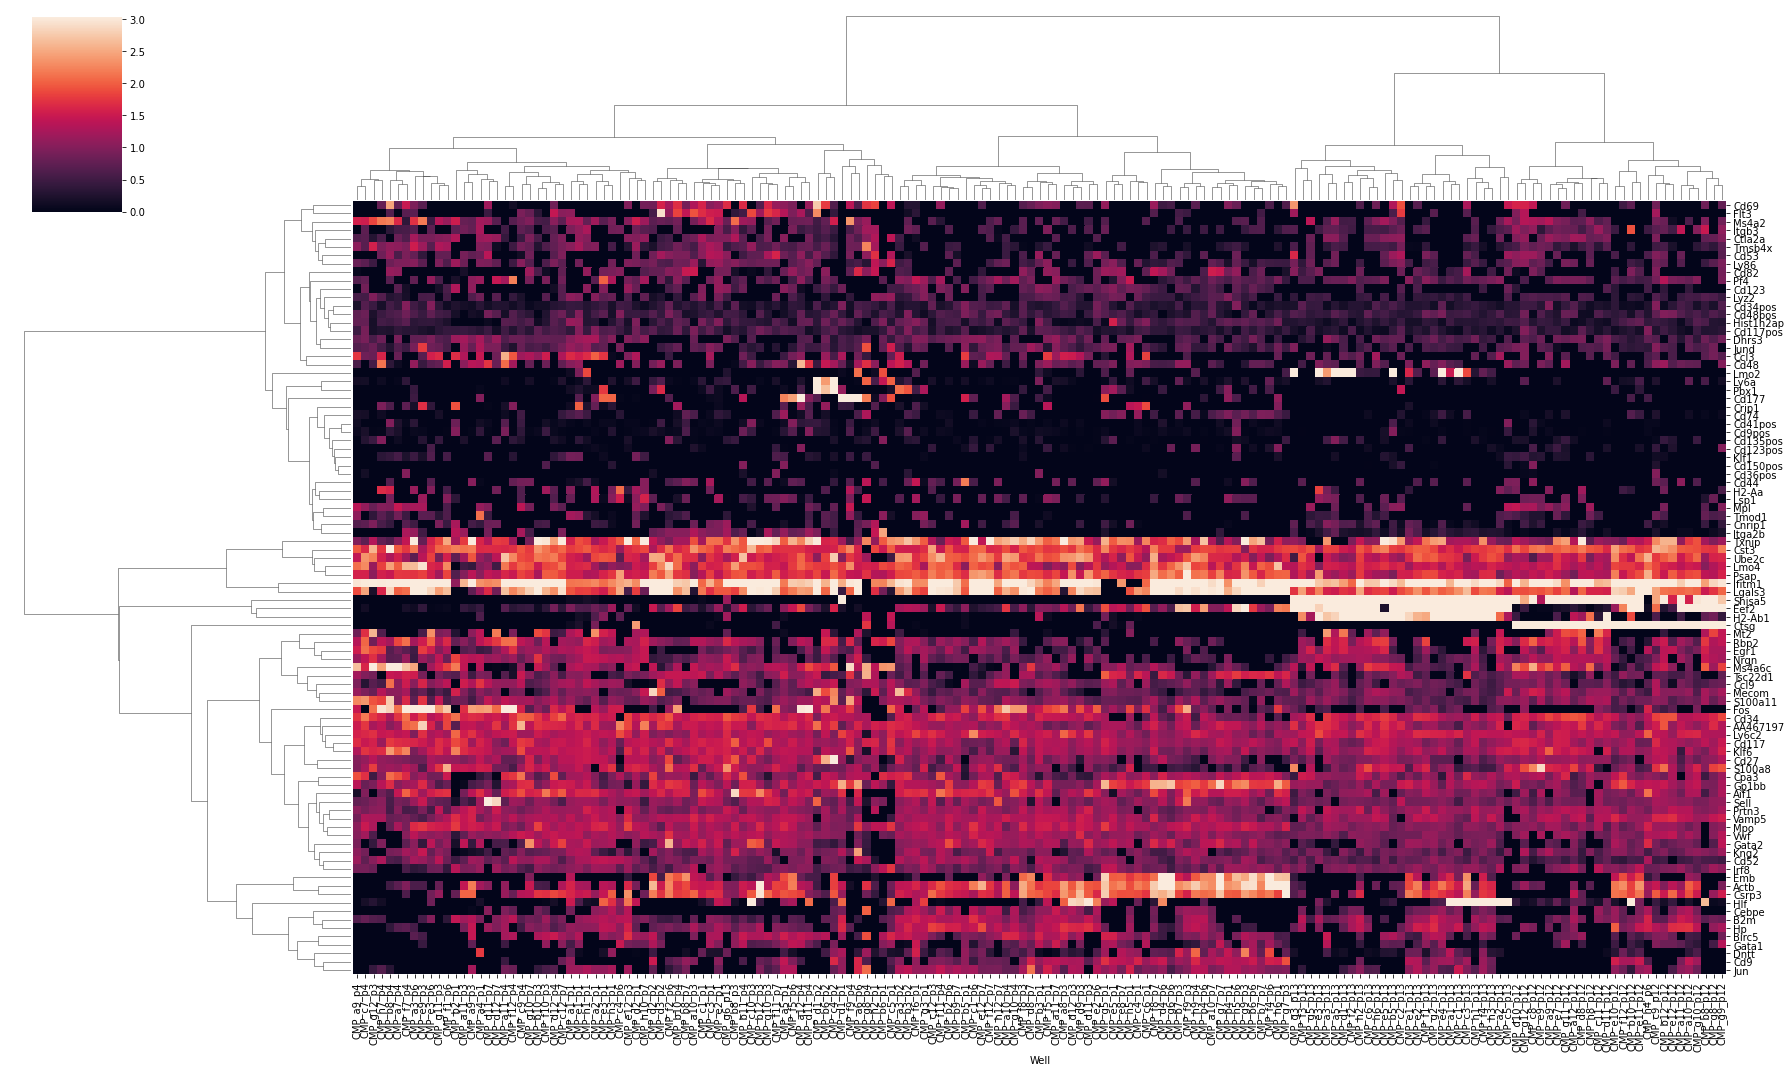

In [117]:
sns.clustermap(combined_df, figsize=(25,15), method = 'ward', robust = True, xticklabels = True, yticklabels = True)

#### Combined cluster: separated

Cluster on rna and mfi; plot with rna on top and mfi on bottom

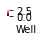

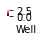

In [118]:
hm_rows = sns.clustermap(combined_df, figsize=(.5,.5), method = 'ward', robust = True, xticklabels = False, yticklabels = False, vmin = 0).dendrogram_row.reordered_ind
hm_cols = sns.clustermap(combined_df, figsize=(.5, .5), method = 'ward', robust = True, xticklabels = False, yticklabels = False, vmin = 0).dendrogram_col.reordered_ind

get the gene order from clustered rna

In [119]:
row_order = []
for pos in hm_rows:
    newrow = combined_df.index[pos]
    row_order.append(newrow)
rna_order = [x for x in row_order if not x.endswith('pos')]
mfi_order = [x for x in row_order if x.endswith('pos')]
combined_rna = combined_df[combined_df.index.isin(rna_order)]
combined_mfi = combined_df[combined_df.index.isin(mfi_order)]

get cell order from clustered rna

In [120]:
col_order = []
for pos in hm_cols:
    newcol = combined_df.columns[pos]
    col_order.append(newcol)

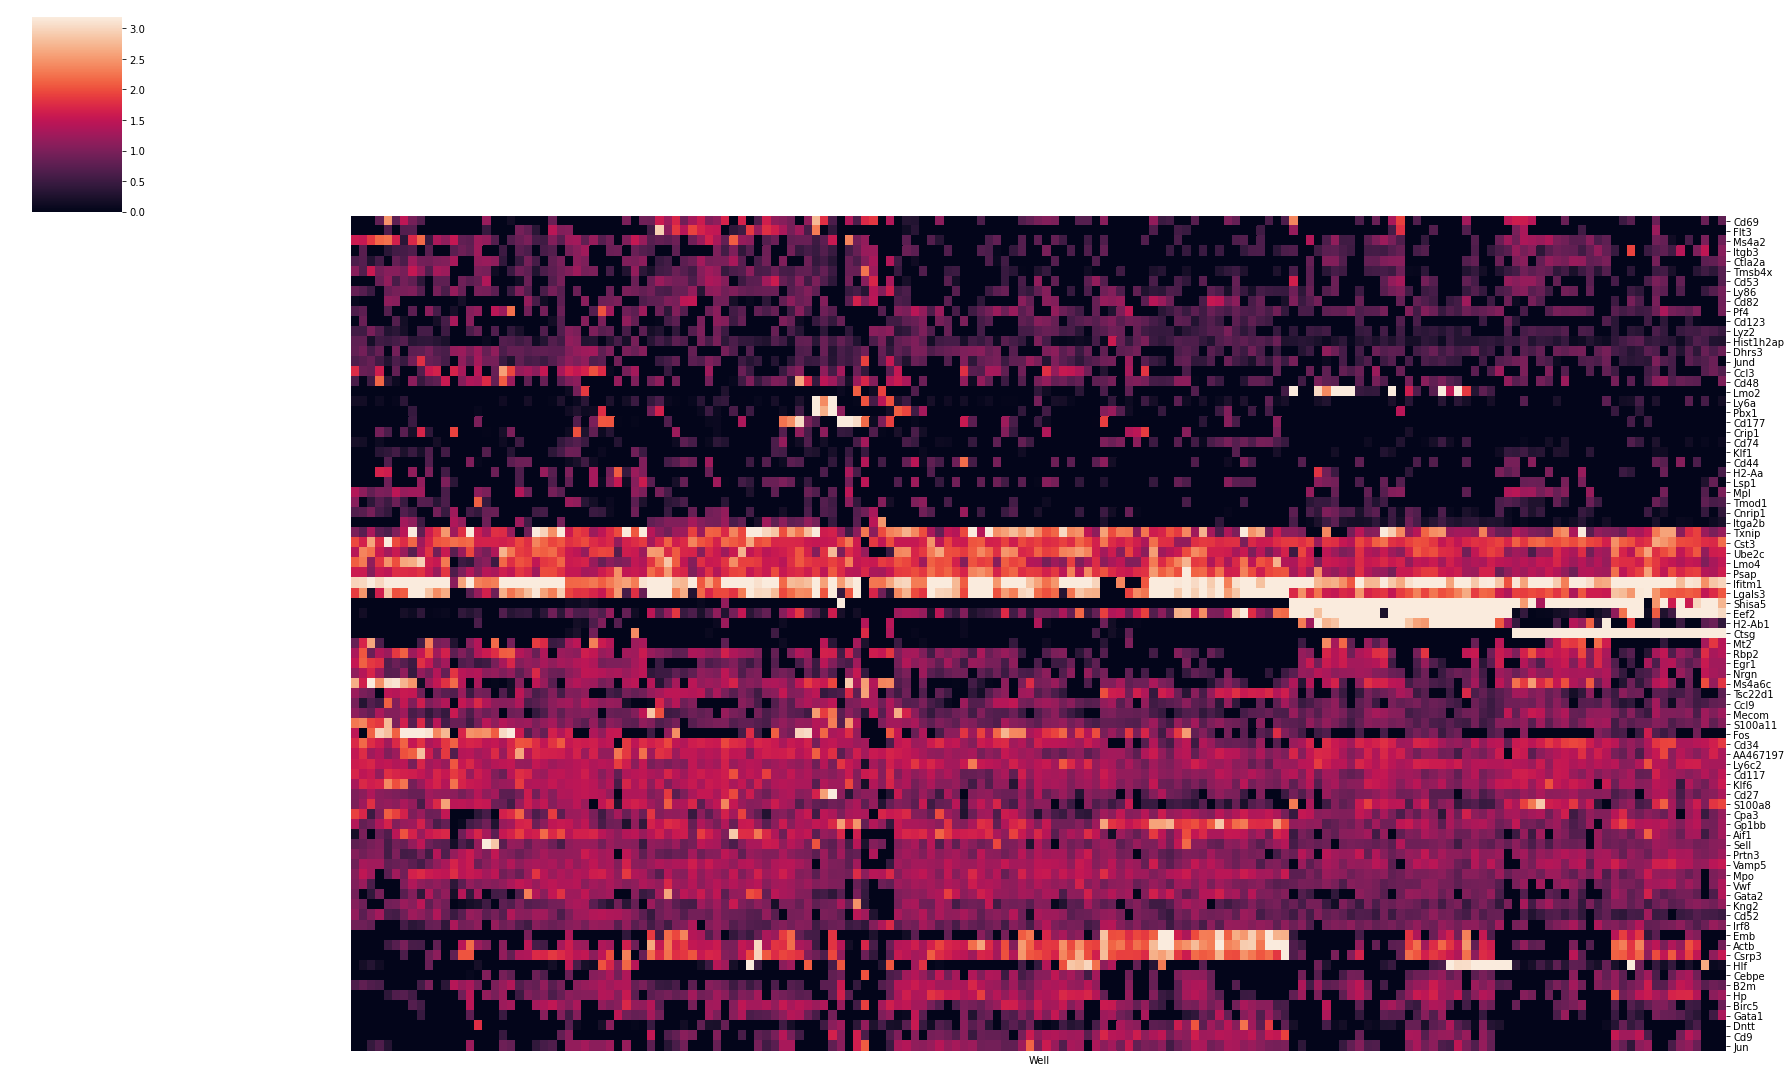

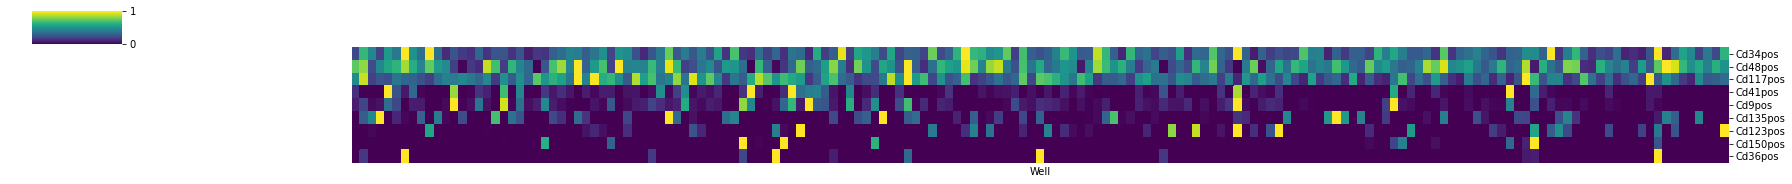

In [126]:
sns.clustermap(combined_rna.reindex(index = rna_order, columns=col_order), figsize = (25, 15), method = 'ward', robust = True, xticklabels = False, yticklabels = True, row_cluster=False, col_cluster = False)
sns.clustermap(combined_mfi.reindex(index = mfi_order, columns=col_order), figsize = (25, 2.5), method = 'ward', robust = True, xticklabels = False, yticklabels = True, row_cluster=False, cmap = 'viridis', col_cluster = False)

### Exclude suspect RNAs

Repeat clustering but exclude Shisa5, Eef2, H2-Ab1, and Ctsg

In [136]:
combined_df = combined_df.drop(['Shisa5', 'Eef2', 'H2-Ab1', 'Ctsg'], axis = 0)

#### Hierarchical cluster

Cluster on biomark and mfi; mfi distributed through rows

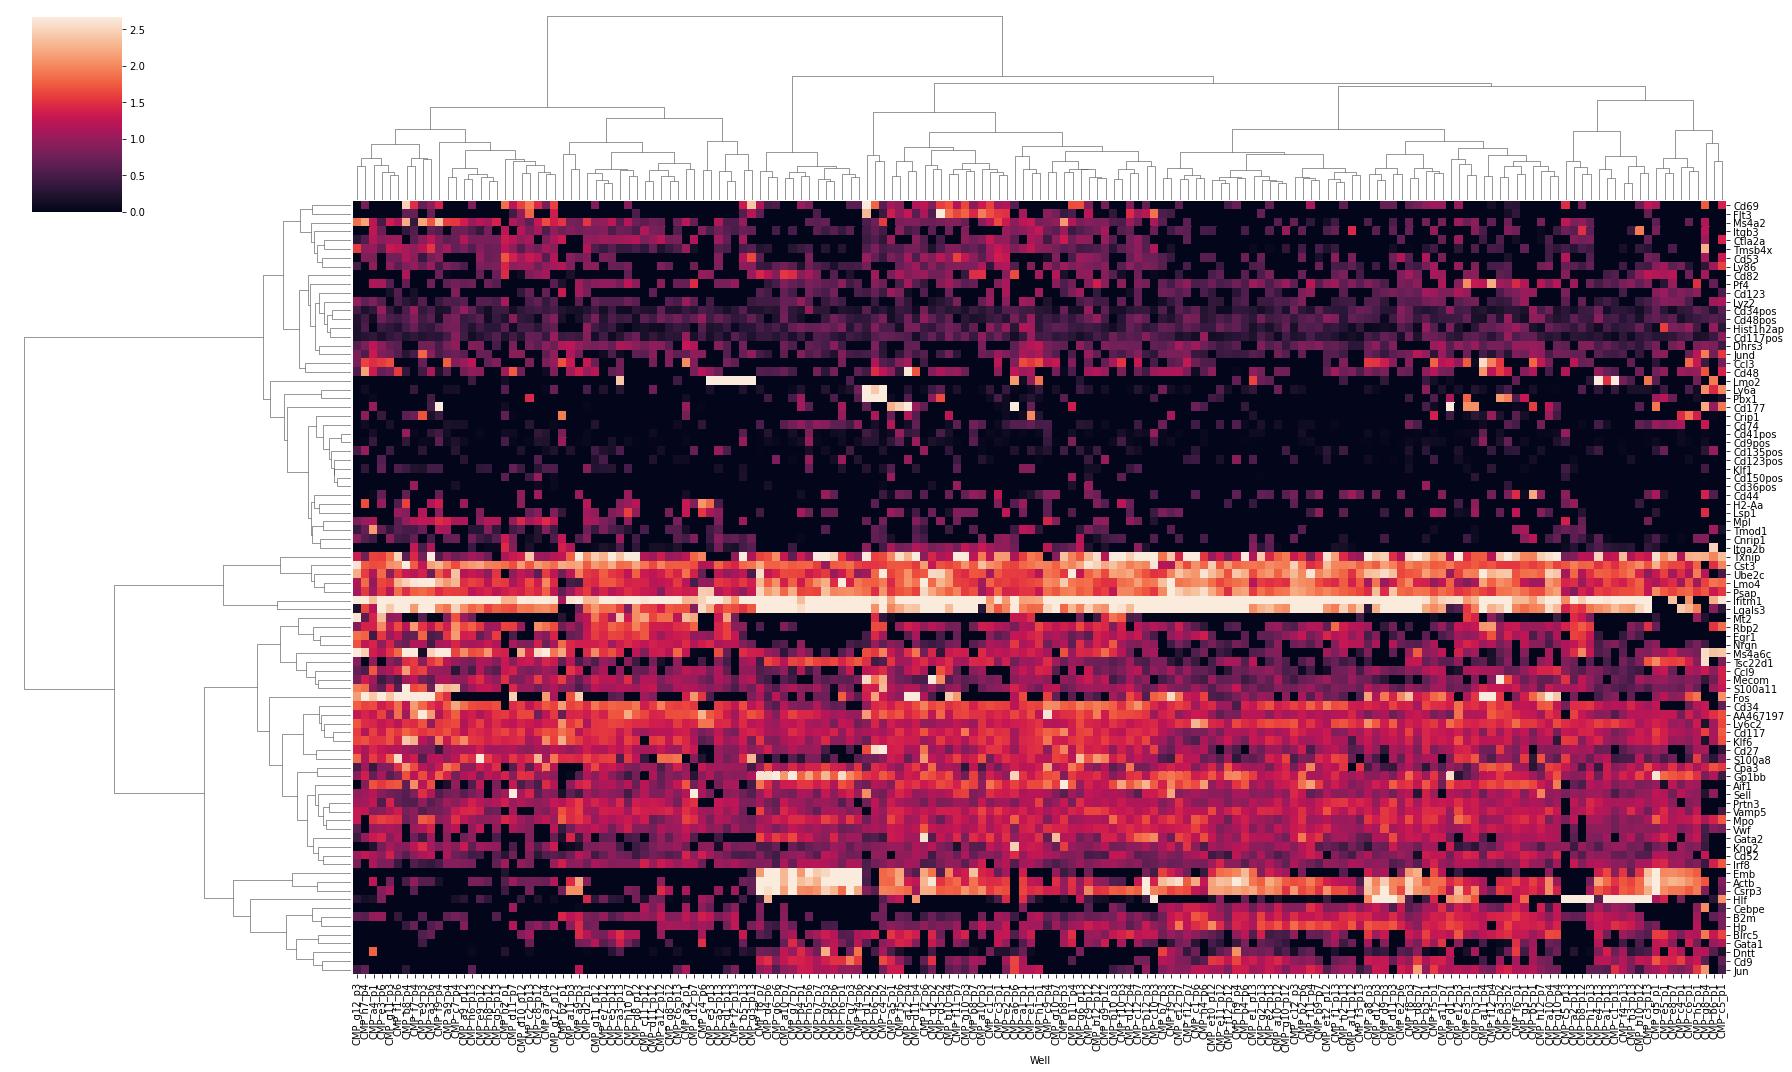

In [137]:
sns.clustermap(combined_df, figsize=(25,15), method = 'ward', robust = True, xticklabels = True, yticklabels = True)

#### Combined cluster: separated

Cluster on rna and mfi; plot with rna on top and mfi on bottom

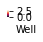

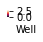

In [143]:
hm_rows = sns.clustermap(combined_df, figsize=(.5,.5), method = 'ward', robust = True, xticklabels = False, yticklabels = False, vmin = 0).dendrogram_row.reordered_ind
hm_cols = sns.clustermap(combined_df, figsize=(.5, .5), method = 'ward', robust = True, xticklabels = False, yticklabels = False, vmin = 0).dendrogram_col.reordered_ind

get the gene order from clustered rna

In [144]:
row_order = []
for pos in hm_rows:
    newrow = combined_df.index[pos]
    row_order.append(newrow)
rna_order = [x for x in row_order if not x.endswith('pos')]
mfi_order = [x for x in row_order if x.endswith('pos')]
combined_rna = combined_df[combined_df.index.isin(rna_order)]
combined_mfi = combined_df[combined_df.index.isin(mfi_order)]

get cell order from clustered rna

In [145]:
col_order = []
for pos in hm_cols:
    newcol = combined_df.columns[pos]
    col_order.append(newcol)

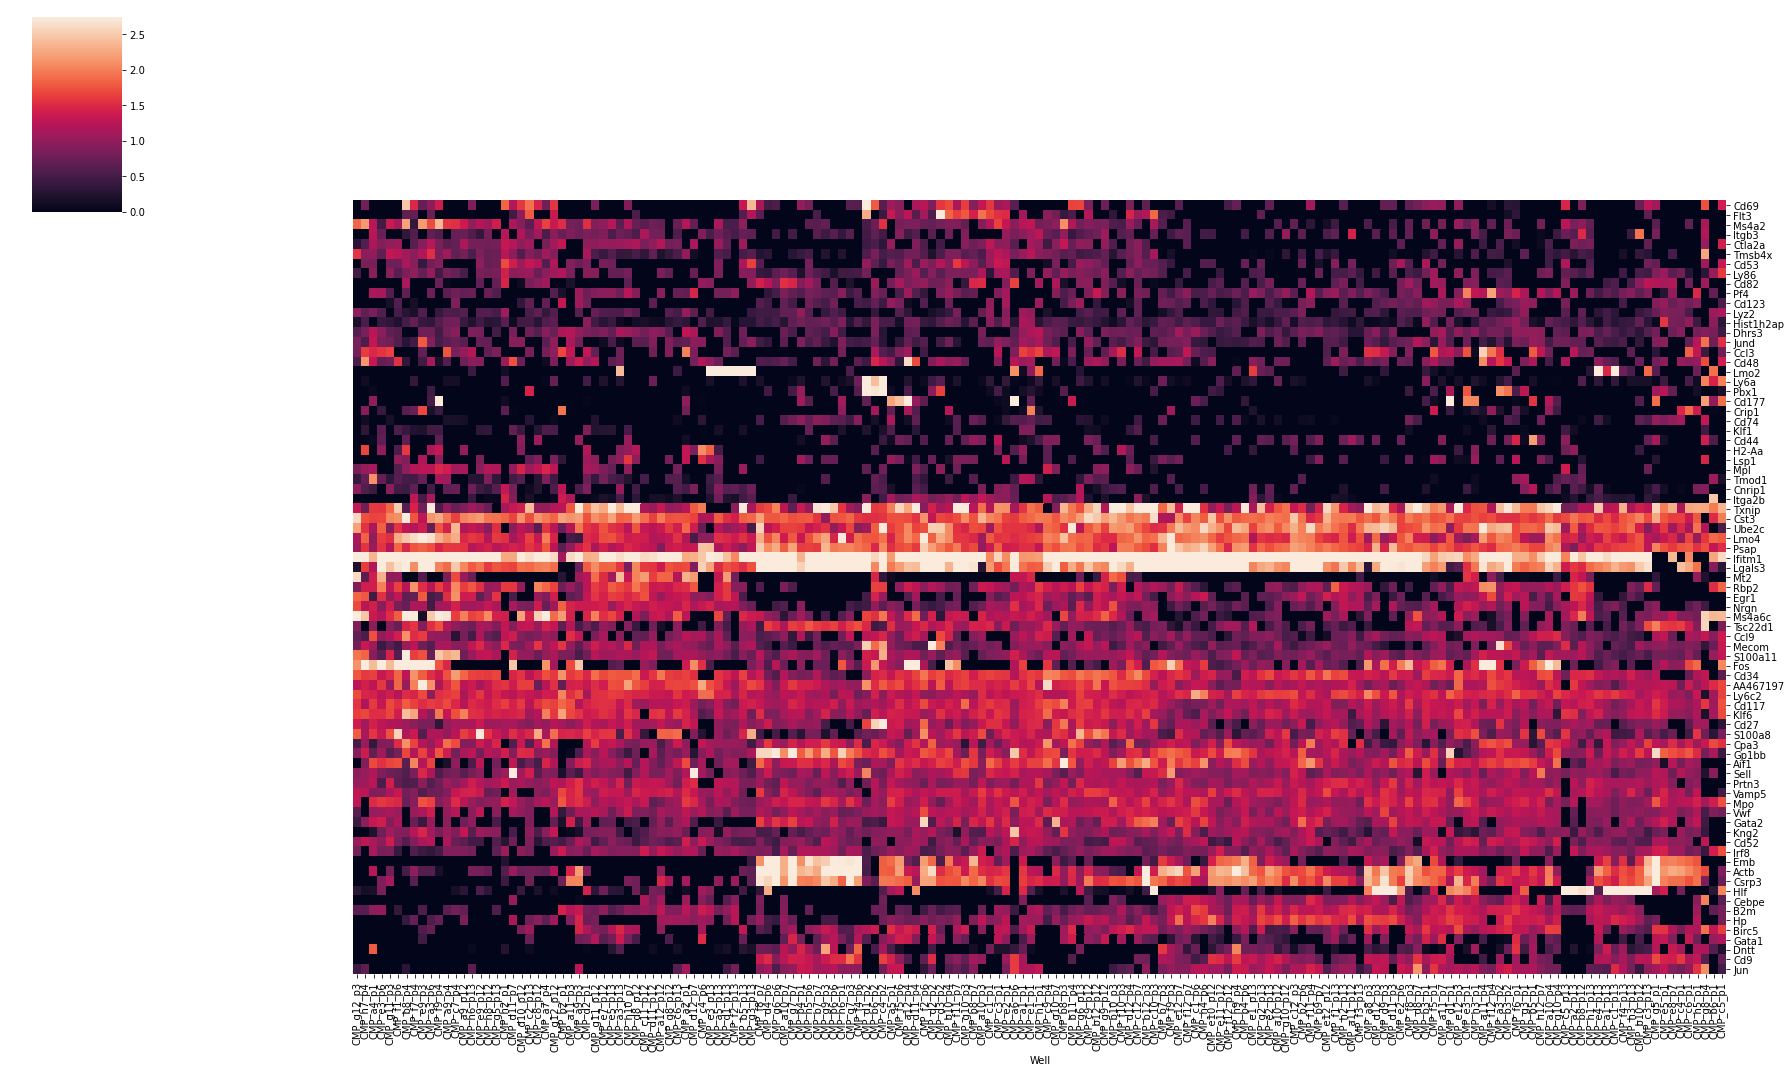

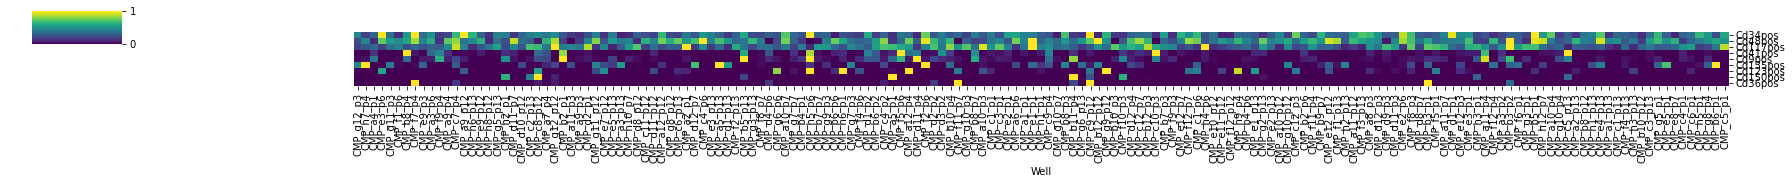

In [146]:
sns.clustermap(combined_rna.reindex(index = rna_order, columns=col_order), figsize = (25, 15), method = 'ward', robust = True, xticklabels = True, yticklabels = True, row_cluster=False, col_cluster = False)
sns.clustermap(combined_mfi.reindex(index = mfi_order, columns=col_order), figsize = (25, 2.5), method = 'ward', robust = True, xticklabels = True, yticklabels = True, row_cluster=False, cmap = 'viridis', col_cluster = False)

##### Get average expression/MFI per group  
Broke ierarchcial clusterings into groups (see lab notebook notes 7.19.21). Can now separate the list of cells (columns) and extract information from each set.  
Have broken it into 9 sets labeled A through J (skipped 'C' because that conventionally means 'cluster')  
> A - 25 cells  
> B - 24 cells  
> D - 13 cells  
> E - 18 cells  
> F - 18 cells  
> G - 15 cells  
> H - 24 cells  
> I - 11 cells  
> J - 9 cells  

In [161]:
cellCount_dict = {'A': 25, 
                 'B': 24,
                 'D': 13,
                 'E': 18,
                 'F': 18,
                 'G': 25,
                 'H': 24,
                 'I': 11,
                 'J': 9
                }

In [182]:
hierarch_dict = {}
col_order_copy = col_order.copy()

for cell_set in cellCount_dict.keys():
    set_range = range(0, cellCount_dict[cell_set])
    cell_list = []
    for pos in set_range: # for each cell in the set range...
        cell_list.append(col_order_copy.pop(0)) # ... take the first cell and add it to the growing list; since 'pop' is mutable, you just have to keep removing the first cell over and over again
        cell_df = combined_df.copy()[cell_list]
    hierarch_dict[cell_set] = cell_df.transpose()


In [164]:
gene_list = ['Pf4', 'Itgb3', 'Itga2b', 'Klf1', 'Lgals3', 'Mt2', 'Gp1bb', 'Mpo', 'Vwf', 'Gata2', 'Irf8', 'Gata1', 'Cd9', 'Cd48', 'Cd44']
mfi_list = ['Cd34pos', 'Cd48pos', 'Cd117pos', 'Cd41pos', 'Cd9pos']

In [274]:
col_list = list(zip(np.repeat(gene_list, 2), ('mean', 'stdev')*len(gene_list)*2))+ list(zip(np.repeat(mfi_list, 2), ('mean', 'stdev')*len(gene_list)*2))
stats_df = pd.DataFrame(index = ['A', 'B', 'D', 'E', 'F', 'G', 'H', 'I', 'J'], columns = col_list)
stats_df.columns = pd.MultiIndex.from_tuples(col_list)
stats_df = stats_df.sort_index()

for cell_set in hierarch_dict.keys():
    for col in stats_df.columns.get_level_values(0):
        stats_df.loc[cell_set, (col, 'mean')] = hierarch_dict[cell_set][col].mean(axis = 0)
        stats_df.loc[cell_set, (col, 'stdev')] = hierarch_dict[cell_set][col].std(axis = 0)

In [276]:
stats_df

Pf4               Itgb3              Itga2b                Klf1  \
       mean     stdev      mean     stdev      mean     stdev      mean   
A  0.364202  0.407068  0.530436   0.43741  0.243634  0.449803    0.2601   
B  0.591662  0.479125   0.64718  0.290679  0.290566  0.368375  0.106122   
D  0.607367  0.246763  0.281509  0.281642  0.030897    0.1114  0.071368   
E  0.573144  0.410765  0.385188  0.383251  0.919626  0.302841  0.108138   
F   0.44306  0.478569  0.673659  0.376419  0.378541  0.449552  0.166456   
G  0.718359  0.250961  0.326442  0.395974  0.094524  0.221791       0.0   
H  0.894342  0.596708  0.268643  0.364023       0.0       0.0  0.026414   
I  0.619917  0.347876   0.53208  0.661734  0.250185  0.164324  0.053362   
J  0.388432  0.556351  0.225347  0.458174  0.303281  0.823655  0.051185   

               Lgals3            ...   Cd34pos             Cd48pos            \
      stdev      mean     stdev  ...      mean     stdev      mean     stdev   
A  0.242606  2.064183  0.692909  ...  0.446757  0.255497  0.487381  0.257848   
B  0.214546  1.513476  0.618064  ...  0.294796   0.15177  0.499241  0.241324   
D  0.203115  3.916987  0.992543  ...  0.338124   0.24725  0.340128  0.261159   
E  0.201596  2.552476  0.885373  ...  0.347264  0.171078  0.437507  0.255467   
F  0.305906   2.46286  0.530836  ...   0.35245  0.248408  0.527562  0.293108   
G       0.0  2.790231  0.588781  ...  0.383202  0.200883  0.537965  0.198734   
H  0.072806  2.110222   0.74711  ...  0.444491  0.260079  0.483896  0.266448   
I  0.139379  2.026253  0.405847  ...   0.32714  0.172011  0.468434  0.204568   
J  0.153554  0.869084  1.051442  ...   0.41967  0.200479   0.48246  0.157311   

   Cd117pos             Cd41pos              Cd9pos            
       mean     stdev      mean     stdev      mean     stdev  
A   0.40146  0.221433  0.123027   0.22435  0.121374   0.17334  
B   0.38412  0.234539  0.068101  0.206172  0.106168  0.278416  
D  0.355918  0.128413  0.120836  0.237374   0.13446   0.26464  
E  0.569369  0.199002  0.230252  0.264261  0.224513  0.271371  
F  0.485911  0.231082  0.125118  0.245282  0.133399  0.238664  
G  0.305772  0.196893  0.023679  0.042957  0.020523  0.034217  
H    0.5193  0.210252  0.062266  0.138351  0.129188  0.226898  
I  0.238658  0.111514  0.094573  0.300425  0.054105  0.130663  
J  0.409241  0.222116  0.015283  0.029316  0.038589  0.047612  

[9 rows x 40 columns]

In [311]:
stats_df.columns.get_level_values(0)

Index(['Pf4', 'Pf4', 'Itgb3', 'Itgb3', 'Itga2b', 'Itga2b', 'Klf1', 'Klf1',
       'Lgals3', 'Lgals3', 'Mt2', 'Mt2', 'Gp1bb', 'Gp1bb', 'Mpo', 'Mpo', 'Vwf',
       'Vwf', 'Gata2', 'Gata2', 'Irf8', 'Irf8', 'Gata1', 'Gata1', 'Cd9', 'Cd9',
       'Cd48', 'Cd48', 'Cd44', 'Cd44', 'Cd34pos', 'Cd34pos', 'Cd48pos',
       'Cd48pos', 'Cd117pos', 'Cd117pos', 'Cd41pos', 'Cd41pos', 'Cd9pos',
       'Cd9pos'],
      dtype='object')

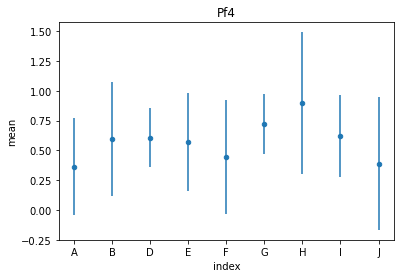

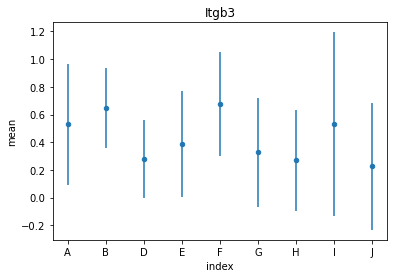

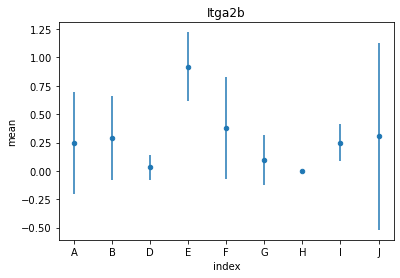

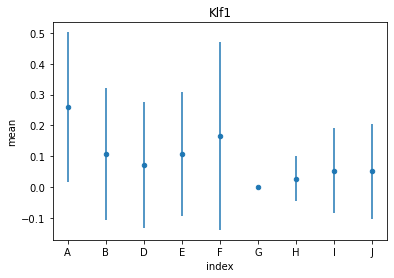

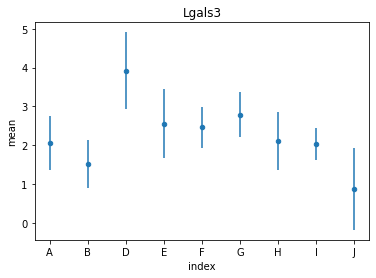

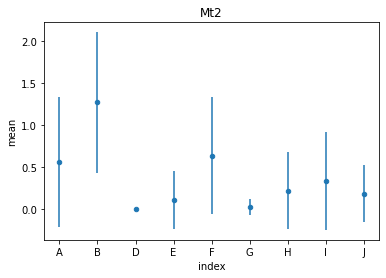

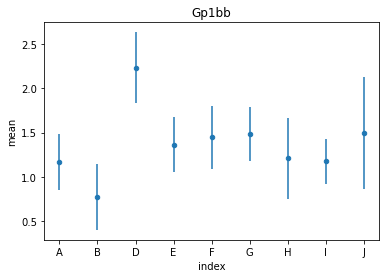

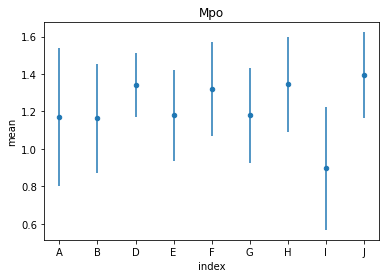

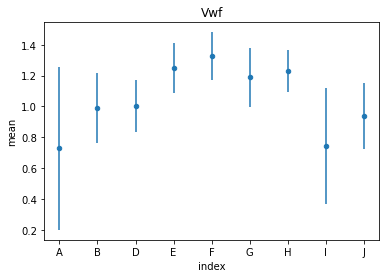

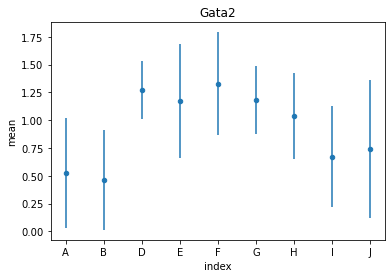

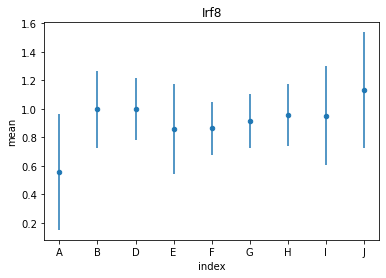

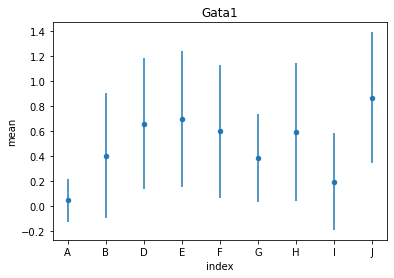

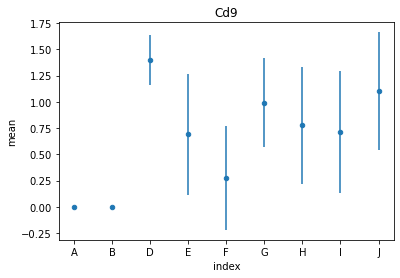

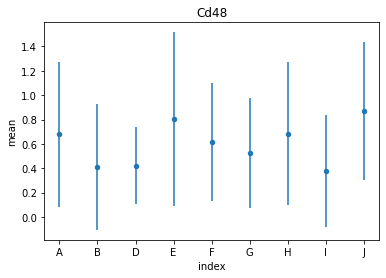

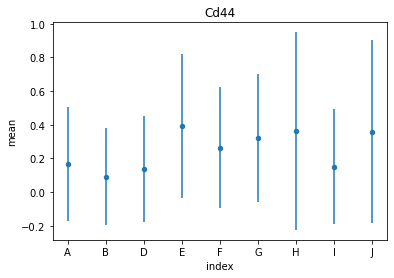

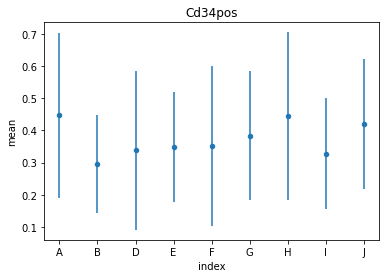

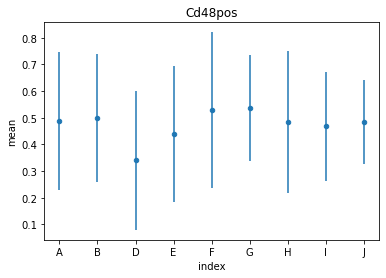

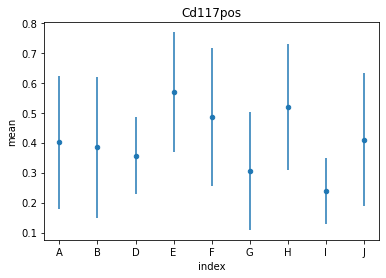

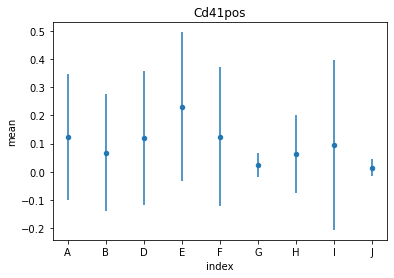

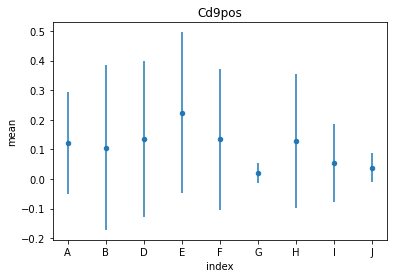

In [323]:
for gene in stats_df.columns.get_level_values(0).unique():
    df = stats_df[gene]
    df = df.reset_index()
    myfig = df.plot(x = 'index', y = 'mean', yerr = 'stdev', kind = 'scatter', title = gene, )


## Cluster columns and rows then add mfi

### get column and row order

In [ ]:
hm_rows = sns.clustermap(rna_zscore, figsize=(1,1), method = 'ward', robust = True, xticklabels = False, yticklabels = True, vmin = 0).dendrogram_row.reordered_ind
hm_cols = sns.clustermap(rna_zscore, figsize=(25,15), method = 'ward', robust = True, xticklabels = True, yticklabels = True, vmin = 0).dendrogram_col.reordered_ind

get the gene order from clustered rna_zscore

In [ ]:
row_order = []
for pos in hm_rows:
    newrow = rna_zscore.index[pos]
    row_order.append(newrow)

get cell order from clustered rna_zscore

In [ ]:
col_order = []
for pos in hm_cols:
    newcol = rna_zscore.columns[pos]
    col_order.append(newcol)

reorder mfi columns to match rna_zscore order

In [ ]:
sns.clustermap(mfi_mtx.transpose().reindex(columns=col_order), figsize=(25,10), method = 'ward', robust = True, xticklabels = False, yticklabels = True, col_cluster=False)

### Do the whole thing in one df

In [ ]:
combined_df = rna_zscore.reindex(index=row_order, columns=col_order).append(mfi_mtx.transpose().reindex(columns=col_order), sort=False)

In [ ]:
sns.clustermap(combined_df, figsize=(25,15), method = 'ward', robust = True, xticklabels = False, yticklabels = True, row_cluster=False, col_cluster=False)

Because gene range is 0 to +infinity, and because marker range is -infinity to +infinity, graphing them on the same heatmap really throws off the colors. Will plot with rna_zscore heatmap and cell-reordered MFI heatmap (see powerpoint).

## Cluster rows-only then add MFI

Another way to do it is to cluster by genes, add the MFI, and let the columns cluster using both gene expression *and* mfi

### get column and row order

In [ ]:
hm_rows = sns.clustermap(rna_zscore, figsize=(1,1), method = 'ward', robust = True, xticklabels = False, yticklabels = True, vmin = 0).dendrogram_row.reordered_ind

get the gene order from clustered rna_zscore

In [ ]:
row_order = []
for pos in hm_rows:
    newrow = rna_zscore.index[pos]
    row_order.append(newrow)

get cell order from clustered rna_zscore

In [ ]:
col_order = []
for pos in hm_cols:
    newcol = rna_zscore.columns[pos]
    col_order.append(newcol)

### Do the whole thing in one df

combine the rna_zscore and MFI dfs, preserving rna_zscore's gene row_order. Also reindex columns in both to col_order to make sure they append properly

In [ ]:
combined_df = rna_zscore.reindex(index=row_order, columns=col_order).append(mfi_mtx.transpose().reindex(columns=col_order), sort=False)

Now plot combined df to get column order

In [ ]:
combined_cols = sns.clustermap(combined_df, figsize=(25,15), method = 'ward', robust = True, xticklabels = False, yticklabels = True, row_cluster=True, col_cluster=True).dendrogram_col.reordered_ind

Get cell order from combined clustered df (`combined_cols` is ordered by position, not cell ID)

In [ ]:
col_order = []
for pos in combined_cols:
    newcol = rna_zscore.columns[pos]
    col_order.append(newcol)

Great! Now to make the two pictures, plot rna_zscore and MFI separately, letting the rows in each cluster but preventing column clustering

reorder rna_zscore columns to match combined_df

In [ ]:
sns.clustermap(rna_zscore.reindex(columns=col_order), figsize=(25,15), method = 'ward', robust = True, xticklabels = False, yticklabels = True, col_cluster=False, row_cluster = True)

reorder mfi_mtx columns to match combined_df

In [ ]:
sns.clustermap(mfi_mtx.transpose().reindex(columns=col_order), figsize=(25,10), method = 'ward', robust = True, xticklabels = False, yticklabels = True, cmap = 'viridis', col_cluster=False, row_cluster = True)

<a id='PlottSNEData'></a>

# Plotting Data as tSNE

## tSNE of LSK, CMP, and MEP

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### PCA

#### RNA zscore + MFI bkgrd

In [ ]:
rna_zscoreT = rna_zscore.transpose()
combined_df = rna_zscoreT.merge(mfi_mtx, how='left', right_on=mfi_mtx.index, left_index=True).drop("key_0", axis = 1).transpose()
cluster_df = combined_df.transpose().copy()

In [ ]:
pid = [str(re.match('.*?([0-9]+)$', x).group(1)) for x in cluster_df.index]
cluster_df['pid'] = pid
cluster_df.head(2)

In [ ]:
pca = PCA(n_components=20)
# pca_result = pca.fit_transform(cluster_df.iloc[:, :-1].values)
pca_result = pca.fit_transform(cluster_df.values)
pca_df = cluster_df.copy()
pca_df['pca-one'] = pca_result[:,0]
pca_df['pca-two'] = pca_result[:,1] 
pca_df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [ ]:
# fig, axes = plt.subplots(1, 2)
plt.figure(figsize=(12, 7))
sns.scatterplot(
#     ax = axes[0], 
    x="pca-one", y="pca-two",
    hue="pid",
    palette=sns.color_palette("hls", len(pca_df['pid'].unique())),
    data=pca_df,
    legend="full",
    alpha=0.7, 
    s = 100
)


In [ ]:
ax = plt.figure(figsize=(10, 10)).gca(projection='3d')
ax.scatter(
    xs=pca_df["pca-one"], 
    ys=pca_df["pca-two"], 
    zs=pca_df["pca-three"], 
    c=pca_df["pid"].astype(int), 
    cmap= 'rainbow', 
    s = 100
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

#### RNA zscore

In [ ]:
pid = [str(re.match('.*?([0-9]+)$', x).group(1)) for x in rna_zscoreT.index]
rna_zscoreT['pid'] = pid
rna_zscoreT.head(2)

In [ ]:
pca = PCA(n_components=3)
# pca_result = pca.fit_transform(rna_df.iloc[:, :-1].values)
pca_result = pca.fit_transform(rna_zscoreT.values)
pca_df = rna_zscoreT.copy()
pca_df['pca-one'] = pca_result[:,0]
pca_df['pca-two'] = pca_result[:,1] 
pca_df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [ ]:
# fig, axes = plt.subplots(1, 2)
plt.figure(figsize=(12, 7))
sns.scatterplot(
#     ax = axes[0], 
    x="pca-one", y="pca-two",
    hue="pid",
    palette=sns.color_palette("hls", len(pca_df['pid'].unique())),
    data=pca_df,
    legend="full",
    alpha=0.7, 
    s = 100
)


#### RNA xprsn

In [ ]:
pid = [str(re.match('.*?([0-9]+)$', x).group(1)) for x in rna_xprsn.index]
rna_xprsn['pid'] = pid
rna_xprsn.head(2)

In [ ]:
rna_xprsn.pid.unique()

In [ ]:
pca = PCA(n_components=3)
# pca_result = pca.fit_transform(rna_df.iloc[:, :-1].values)
pca_result = pca.fit_transform(rna_xprsn.values)
pca_df = rna_xprsn.copy()
pca_df['pca-one'] = pca_result[:,0]
pca_df['pca-two'] = pca_result[:,1] 
pca_df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [ ]:
# fig, axes = plt.subplots(1, 2)
plt.figure(figsize=(12, 7))
sns.scatterplot(
#     ax = axes[0], 
    x="pca-two", y="pca-three",
    hue="pid",
    palette=sns.color_palette("hls", len(pca_df['pid'].unique())),
    data=pca_df,
    legend="full",
    alpha=0.7, 
    s = 100
)


In [ ]:
ax = plt.figure(figsize=(10, 10)).gca(projection='3d')
ax.scatter(
    xs=pca_df["pca-one"], 
    ys=pca_df["pca-two"], 
    zs=pca_df["pca-three"], 
    c=pca_df["pid"].astype(int), 
    cmap= 'Set1', 
    s = 100
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

#### PCA mfi

In [ ]:
mfi_df = combined_df.transpose().copy()
mfi_df = mfi_df.iloc[:, -9:]

In [ ]:
pid = [str(re.match('.*?([0-9]+)$', x).group(1)) for x in mfi_df.index]
mfi_df['pid'] = pid
mfi_df.head(2)

In [ ]:
pca = PCA(n_components=3)
# pca_result = pca.fit_transform(mfi_df.iloc[:, :-1].values)
pca_result = pca.fit_transform(mfi_df.values)
pca_df = mfi_df.copy()
pca_df['pca-one'] = pca_result[:,0]
pca_df['pca-two'] = pca_result[:,1] 
pca_df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [ ]:
# fig, axes = plt.subplots(1, 2)
plt.figure(figsize=(12, 7))
sns.scatterplot(
#     ax = axes[0], 
    x="pca-one", y="pca-two",
    hue="pid",
    palette=sns.color_palette("hls", len(pca_df['pid'].unique())),
    data=pca_df,
    legend="full",
    alpha=0.7, 
    s = 100
)


In [ ]:
ax = plt.figure(figsize=(10, 10)).gca(projection='3d')
ax.scatter(
    xs=pca_df["pca-one"], 
    ys=pca_df["pca-two"], 
    zs=pca_df["pca-three"], 
    c=pca_df["pid"].astype(int), 
    cmap= 'Set1', 
    s = 100
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### TSNE

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# tsne_results = tsne.fit_transform(cluster_df.iloc[:,:-1])
tsne_results = tsne.fit_transform(cluster_df)

In [ ]:
tsne_df = cluster_df.copy()
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="pid",
    palette=sns.color_palette("hls", len(tsne_df.pid.unique())),
    data=tsne_df,
    legend="full",
    alpha=1,
    s = 100
)

In [ ]:
X = mnist.data / 255.0
y = mnist.target
print(X.shape, y.shape)

In [ ]:
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

In [ ]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

In [ ]:
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(df.loc[rndperm[i],'label'])) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

In [ ]:
df

In [ ]:
df

In [ ]:
rndperm

# Normalization Notes

[Bioconductor Support Article](https://support.bioconductor.org/p/34182/)

Other approaches

[Published data analysis for 96.96 Dynamic Array IFC](https://www.gene-quantification.de/livak-methods-59-transcriptional-biomarkers-2013.pdf)  
* Data analyzed using Fluidigm Real-Time PCR Analysis software  
    * Used linear (derivative) baseline correction method  
    * Used Auto (global) Ct threshold method (alt. 0.01)
    * Ct range 12 - 28 cycles
    * Export Cq values  

[G. Guo, Dev. Cell; 18 (2010) 675–685.](https://www.sciencedirect.com/science/article/pii/S1534580710001103#sec4)
* Relative expression determined by subtracting Ct value from "assumed baseline of 28"
* Remove cells with absent/low endogenous controls (~10%)
* Normalize these by subtracting average of ActB+GAPDH expression levels

[geNorm method](https://doi.org/10.1186/gb-2002-3-7-research0034)
* Average control genes using __geometric mean__ (not arithmatic mean)
    * genorm support stops with python 2.7 
    * R may have an implementation for it via [NormqPCR](https://www.bioconductor.org/packages/release/bioc/html/NormqPCR.html)
    
[ERgene](https://www.nature.com/articles/s41598-020-75586-5)
* Python library to for gene nomralization [github](https://github.com/Starlitnightly/ERgene)

[Beth Psaila's Approach](https://doi.org/10.1186/s13059-016-0939-7)
* Exclude assays with:
    * LOD (limit of detection) >= 40
* Exclude cells with:
    * >70 failed assays
    * B2M >= 13
    * GAPDH >= 15
    * Cells with mean Ct > 20
* Norm to average of [B2M & GAPDH]
* Expression = 2^-(NormCt)
* Exclude HKgenes

Going with Beth's method because it's the most thoroughly described.
Might also gofor quantile nomrlization